# Artificial Neural Networks and Deep Learning

---

## Lecture 6b: Generative Adversarial Networks

<img src="https://drive.google.com/uc?export=view&id=1dxxXvi8Bm3MEunIoRvIKdF_JI1o7YxC-" width="500"/>

## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Lecture 6

## ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
from PIL import Image
import glob
import shutil

# Configure plot display settings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## 📊 Setup Hyperparameters

In [2]:
# Define training hyperparameters
epochs = 50
learning_rate = 5e-5
batch_size = 64
latent_dim = 64

# Print current parameters
print(f"Parameters defined:\n"
      f"  epochs:        {epochs:>8}\n"
      f"  learning_rate: {learning_rate:>8.1e}\n"
      f"  batch_size:    {batch_size:>8}\n"
      f"  latent_dim:    {latent_dim:>8}")

Parameters defined:
  epochs:              50
  learning_rate:  5.0e-05
  batch_size:          64
  latent_dim:          64


## ⏳ Load and Process Data

In [3]:
# Load the Fashion MNIST dataset
(X_train_val, y_train_val), (X_test, y_test) = tfk.datasets.fashion_mnist.load_data()

# Add channel dimension to data
X_train_val = X_train_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Resize images to 32x32
X_train_val = tfk.preprocessing.image.smart_resize(X_train_val, (32, 32))
X_test = tfk.preprocessing.image.smart_resize(X_test, (32, 32))

# Normalise pixel values to range [-1, 1]
X_train_val = (X_train_val.astype('float32') - 127.5) / 127.5
X_test = (X_test.astype('float32') - 127.5) / 127.5

# Print shapes of training and test data
print("Training data shape:", X_train_val.shape)
print("Test data shape:", X_test.shape)

# Define class names for the dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(class_names)

# Concatenate training and test data
X = np.concatenate([X_train_val, X_test], axis=0)
y = np.concatenate([y_train_val, y_test], axis=0).astype('int32')

# Print shapes of concatenated data
print(f"Combined data shape: X={X.shape}, y={y.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 32, 32, 1)
Test data shape: (10000, 32, 32, 1)
Combined data shape: X=(70000, 32, 32, 1), y=(70000,)


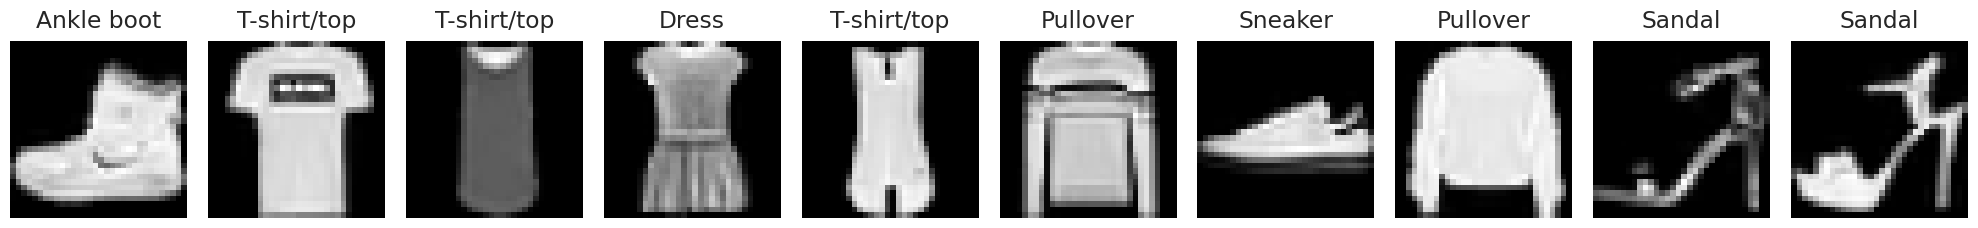

In [4]:
# Inspect sample images from the training data
fig, axes = plt.subplots(1, 10, figsize=(20, 10))

# Loop through the first 10 images
for i in range(10):
    ax = axes[i % 10]

    # Display image and its corresponding label
    ax.imshow(np.squeeze(X_train_val[i]), cmap='gray')
    ax.set_title(class_names[y_train_val[i]], pad=10)
    ax.axis('off')

# Adjust layout for better visualisation
plt.tight_layout()
plt.show()

In [5]:
# Print shape and statistical properties of the dataset
print('Data shape:', X.shape)
print('Data min: {:0.2f}\nData max: {:0.2f}\nData mean: {:0.2f}\nData std: {:0.2f}'.format(
    X.min(), X.max(), X.mean(), X.std()))

# Define input shape for the model
input_shape = X.shape[1:]

# Print input shape
print(f"Input shape: {input_shape}")

Data shape: (70000, 32, 32, 1)
Data min: -1.00
Data max: 1.00
Data mean: -0.43
Data std: 0.68
Input shape: (32, 32, 1)


## 🛠️ Generative Adversarial Network (GAN)

<img src="https://drive.google.com/uc?export=view&id=19PsuOIjonMAvecVBeEto0sTea2EviNgW" width="700"/>

**Variables and Parameters**

$D$: Discriminator network (outputs probability between 0 and 1)

$G$: Generator network (creates synthetic samples)

$x$: Input data samples

$p_r(x)$: Probability distribution of real data samples

$p_g(x)$: Probability distribution of generated (fake) samples

$L(G,D)$: Loss function to be optimized

$\mathbb{E}$: Expected value operator

**Formula**

$$
\min_{G} \max_{D} L(G,D) = \mathbb{E}_{x \sim p_r(x)}[\log(D(x))] + \mathbb{E}_{x \sim p_g(x)}[\log(1-D(x))]
$$

**Description**

This formula represents the core objective function of a Generative Adversarial Network (GAN). It establishes a minimax game between two neural networks:

1. The discriminator (D) aims to maximize the function by correctly classifying real and fake samples
2. The generator (G) aims to minimize the function by creating samples that fool the discriminator
3. The $\log(D(x))$ term rewards the discriminator for correctly identifying real samples
4. The $\log(1-D(x))$ term rewards the discriminator for correctly identifying fake samples

Theoretically, at equilibrium, this adversarial process should result in the generator producing samples that are indistinguishable from real data, while the discriminator's predictions converge to 0.5 for both real and generated samples.

In [6]:


# Define a function to build the discriminator model
def get_discriminator(input_shape, seed=seed):
    # Set random seed for reproducibility
    tf.random.set_seed(seed)

    # Define input layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # First convolutional block
    x = tfkl.Conv2D(32, 4, padding='same', strides=2, name='conv1')(input_layer)
    x = tfkl.LayerNormalization(name='ln1')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(x)

    # Second convolutional block
    x = tfkl.Conv2D(64, 4, padding='same', strides=2, name='conv2')(x)
    x = tfkl.LayerNormalization(name='ln2')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(x)

    # Third convolutional block
    x = tfkl.Conv2D(128, 4, padding='same', strides=2, name='conv3')(x)
    x = tfkl.LayerNormalization(name='ln3')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation3')(x)

    # Global average pooling and dense layers for classification
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    x = tfkl.Dense(256, name='dense1')(x)
    x = tfkl.LayerNormalization(name='ln4')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation4')(x)
    output_layer = tfkl.Dense(1, name='dense_out')(x)

    # Return the discriminator model
    return tf.keras.Model(inputs=input_layer, outputs=output_layer, name='discriminator')

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, 32, 32, 1)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 16, 16, 32)           │           544 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ ln1 (LayerNormalization)            │ (None, 16, 16, 32)           │            64 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation1 (LeakyReLU)             │ (None, 16, 16, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 8, 8, 64)             │        32,832 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ ln2 (LayerNormalization)            │ (None, 8, 8, 64)             │           128 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation2 (LeakyReLU)             │ (None, 8, 8, 64)             │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv3 (Conv2D)                      │ (None, 4, 4, 128)            │       131,200 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ ln3 (LayerNormalization)            │ (None, 4, 4, 128)            │           256 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation3 (LeakyReLU)             │ (None, 4, 4, 128)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ gap (GlobalAveragePooling2D)        │ (None, 128)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense1 (Dense)                      │ (None, 256)                  │        33,024 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ ln4 (LayerNormalization)            │ (None, 256)                  │           512 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation4 (LeakyReLU)             │ (None, 256)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_out (Dense)                   │ (None, 1)                    │           257 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 198,817 (776.63 KB)

 Trainable params: 198,817 (776.63 KB)

 Non-trainable params: 0 (0.00 B)

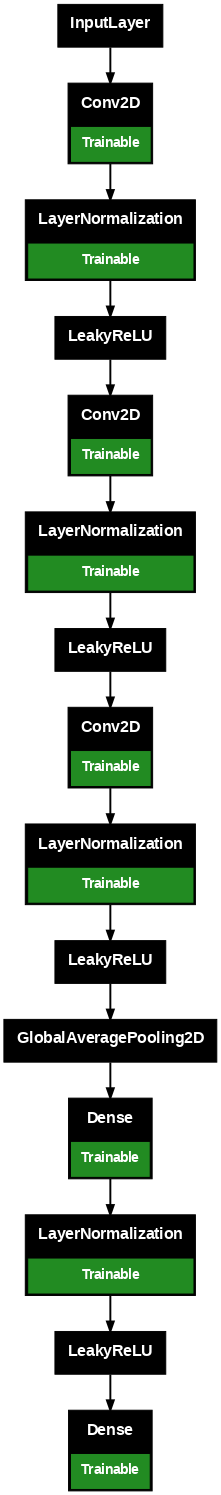

In [7]:
# Instantiate the discriminator model
discriminator = get_discriminator(input_shape)

# Print a detailed summary of the discriminator
discriminator.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the discriminator architecture
tf.keras.utils.plot_model(
    discriminator,
    show_trainable=True,
    expand_nested=True,
    dpi=70
)

In [8]:
# Define a function to build the generator model
def get_generator(input_shape, seed=seed):
    # Set random seed for reproducibility
    tf.random.set_seed(seed)

    # Define input layer
    input_layer = tfkl.Input(shape=(input_shape,), name='Input')

    # Dense layer to expand input to a 4x4x64 feature map
    x = tfkl.Dense(4 * 4 * 64, use_bias=False, name='dense0')(input_layer)
    x = tfkl.LayerNormalization(name='ln0')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation0')(x)
    x = tfkl.Reshape((4, 4, 64))(x)

    # First upsampling block
    x = tfkl.UpSampling2D(name='upsampling1')(x)
    x = tfkl.Conv2D(64, 3, padding='same', use_bias=False, name='conv1')(x)
    x = tfkl.LayerNormalization(name='bn1')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(x)

    # Second upsampling block
    x = tfkl.UpSampling2D(name='upsampling2')(x)
    x = tfkl.Conv2D(128, 3, padding='same', use_bias=False, name='conv2')(x)
    x = tfkl.LayerNormalization(name='bn2')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(x)

    # Third upsampling block
    x = tfkl.UpSampling2D(name='upsampling3')(x)
    x = tfkl.Conv2D(256, 3, padding='same', use_bias=False, name='conv3')(x)
    x = tfkl.LayerNormalization(name='bn3')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation3')(x)

    # Output layer with a single channel and tanh activation
    x = tfkl.Conv2D(1, 3, padding='same', use_bias=False, name='conv_out')(x)
    output_layer = tfkl.Activation('tanh', name='activation_out')(x)

    # Return the generator model
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='generator')
    return model

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 64)                   │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense0 (Dense)                      │ (None, 1024)                 │        65,536 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ ln0 (LayerNormalization)            │ (None, 1024)                 │         2,048 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation0 (LeakyReLU)             │ (None, 1024)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ reshape (Reshape)                   │ (None, 4, 4, 64)             │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ upsampling1 (UpSampling2D)          │ (None, 8, 8, 64)             │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 8, 8, 64)             │        36,864 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ bn1 (LayerNormalization)            │ (None, 8, 8, 64)             │           128 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation1 (LeakyReLU)             │ (None, 8, 8, 64)             │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ upsampling2 (UpSampling2D)          │ (None, 16, 16, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 16, 16, 128)          │        73,728 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ bn2 (LayerNormalization)            │ (None, 16, 16, 128)          │           256 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation2 (LeakyReLU)             │ (None, 16, 16, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ upsampling3 (UpSampling2D)          │ (None, 32, 32, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv3 (Conv2D)                      │ (None, 32, 32, 256)          │       294,912 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ bn3 (LayerNormalization)            │ (None, 32, 32, 256)          │           512 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation3 (LeakyReLU)             │ (None, 32, 32, 256)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv_out (Conv2D)                   │ (None, 32, 32, 1)            │         2,304 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation_out (Activation)         │ (None, 32, 32, 1)            │             0 │    -    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 476,288 (1.82 MB)

 Trainable params: 476,288 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

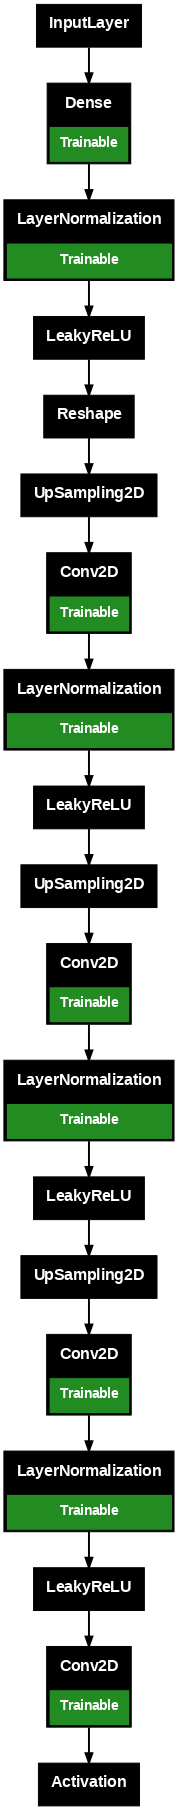

In [9]:
# Obtain a generator model based on the specified latent dimension
generator = get_generator(latent_dim)

# Print a detailed summary of the generator, including expanded nested layers and trainable parameters
generator.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the generator architecture
tf.keras.utils.plot_model(
    generator,
    show_trainable=True,
    expand_nested=True,
    dpi=70
)

In [10]:
# Define a GAN class inheriting from tf.keras.Model
class GAN(tfk.Model):

    # Initialise the GAN with a discriminator, generator, latent dimension, and discriminator update frequency
    def __init__(self, discriminator, generator, latent_dim, n_discriminator_updates=3):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.n_discriminator_updates = n_discriminator_updates

        # Initialise loss trackers for discriminator and generator
        self.d_loss_tracker = tfk.metrics.Mean(name="d_loss")
        self.g_loss_tracker = tfk.metrics.Mean(name="g_loss")

    # Compile the GAN with optimisers and an optional loss function
    def compile(self, d_optimizer, g_optimizer, loss_fn=None):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn or tfk.losses.BinaryCrossentropy(from_logits=True)

    # Define GAN metrics
    @property
    def metrics(self):
        return [self.d_loss_tracker, self.g_loss_tracker]

    # Compute generator loss
    def _generator_loss(self, fake_output):
        return self.loss_fn(tf.ones_like(fake_output), fake_output)

    # Compute discriminator loss
    def _discriminator_loss(self, real_output, fake_output):
        real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
        fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    # Define the training step
    @tf.function
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Train discriminator multiple times
        d_loss = 0
        for _ in range(self.n_discriminator_updates):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                generated_images = self.generator(random_latent_vectors, training=True)
                real_output = self.discriminator(real_images, training=True)
                fake_output = self.discriminator(generated_images, training=True)
                current_d_loss = self._discriminator_loss(real_output, fake_output)

            # Update discriminator weights
            grads = tape.gradient(current_d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
            d_loss += current_d_loss / self.n_discriminator_updates

        # Generate random latent vectors
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train generator
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            fake_output = self.discriminator(generated_images, training=False)
            g_loss = self._generator_loss(fake_output)

        # Update generator weights
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update loss trackers
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)

        # Return loss metrics
        return {
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result()
        }

In [11]:
# Define a GANMonitor callback to visualise generated images during training
class GANMonitor(tfk.callbacks.Callback):

    # Initialise the callback with the number of images, latent dimension, name, and colour mode
    def __init__(self, num_img=10, latent_dim=latent_dim, name='', gray=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.name = name
        self.gray = gray

    # Generate and display images at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        # Set random seed for reproducibility
        tf.random.set_seed(seed)

        # Ensure output directory exists
        os.makedirs(self.name + 'temp', exist_ok=True)

        # Generate latent vectors and images
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors).numpy()
        generated_images = generated_images * 0.5 + 0.5  # Rescale pixel values

        # Plot generated images
        fig, axes = plt.subplots(1, self.num_img, figsize=(20, self.num_img))
        for i in range(self.num_img):
            img = tfk.preprocessing.image.array_to_img(generated_images[i])
            ax = axes[i % self.num_img]
            if self.gray:
                ax.imshow(np.squeeze(img), cmap='gray')
            else:
                ax.imshow(np.squeeze(img))
            ax.axis('off')

        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()

In [12]:
# Create an instance of the GAN model with specified discriminator, generator, and latent dimension
gan = GAN(
    discriminator=get_discriminator(input_shape),
    generator=get_generator(latent_dim),
    latent_dim=latent_dim
)

# Compile the GAN model with Adam optimisers for both discriminator and generator
gan.compile(
    d_optimizer=tfk.optimizers.AdamW(learning_rate=learning_rate, beta_1=0.5, beta_2=0.999),
    g_optimizer=tfk.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.999)
)

In [13]:
# Generate and display sample images from a model
def sample(model, num_img, latent_dim, fixed=True, gray=False):
    # Optionally set a fixed random seed for reproducibility
    if fixed:
        tf.random.set_seed(seed)

    # Generate random latent vectors and produce images
    z = tf.random.normal(shape=(num_img, latent_dim))
    generated_images = model(z).numpy()
    generated_images = generated_images * 0.5 + 0.5  # Rescale pixel values

    # Plot the generated images
    fig, axes = plt.subplots(1, num_img, figsize=(20, num_img))
    for i in range(num_img):
        img = tfk.preprocessing.image.array_to_img(generated_images[i])
        ax = axes[i % num_img]
        if gray:
            ax.imshow(np.squeeze(img), cmap='gray')
        else:
            ax.imshow(np.squeeze(img))
        ax.axis('off')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Generate a dataset of images from a model
def generate_dataset(model, num_img, latent_dim, fixed=True):
    # Optionally set a fixed random seed for reproducibility
    if fixed:
        tf.random.set_seed(seed)

    # Generate random latent vectors and produce images
    z = tf.random.normal(shape=(num_img, latent_dim))
    generated_images = model(z).numpy()
    generated_images = generated_images * 0.5 + 0.5  # Rescale pixel values

    # Return the generated dataset
    return generated_images

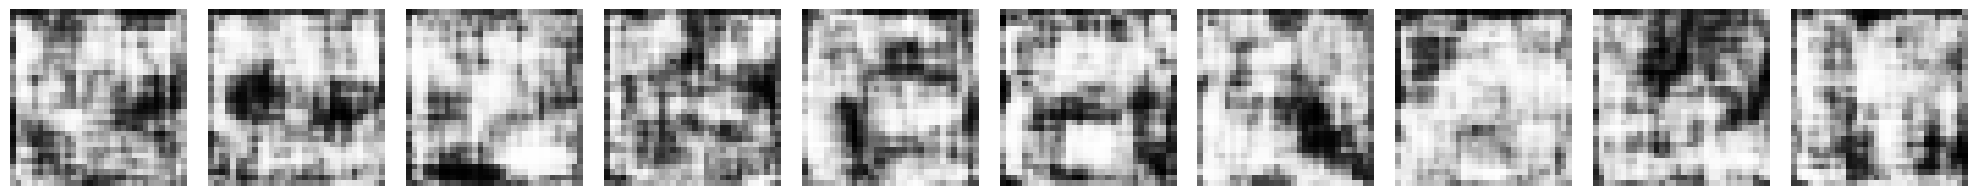

In [14]:
# Generate and display 10 sample images from the GAN's generator
# Disable fixed random seed and display images in grayscale
sample(gan.generator, 10, latent_dim, fixed=False, gray=True)

Epoch 1/50


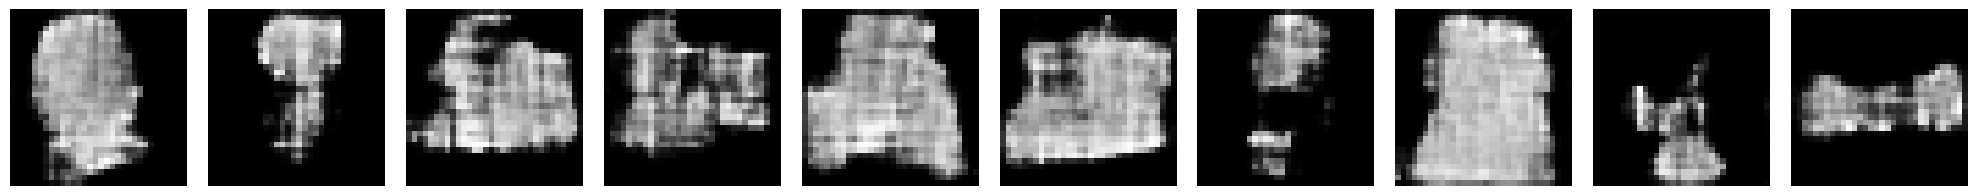

1094/1094 - 110s - 101ms/step - d_loss: 0.4496 - g_loss: 2.6519
Epoch 2/50


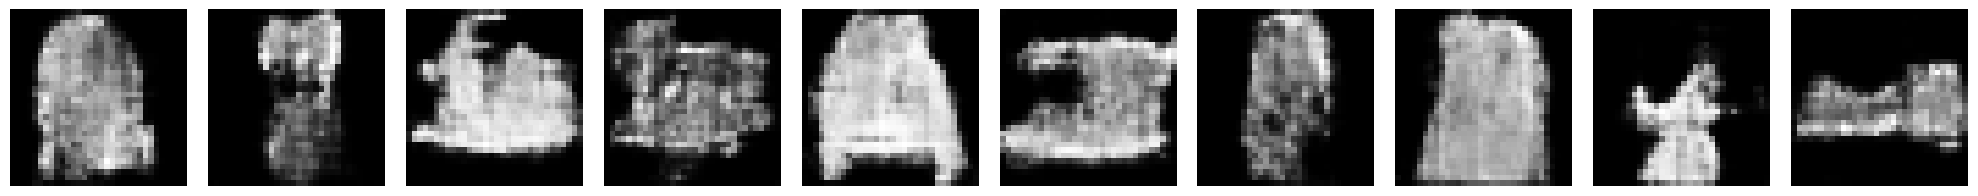

1094/1094 - 58s - 53ms/step - d_loss: 0.3778 - g_loss: 3.0272
Epoch 3/50


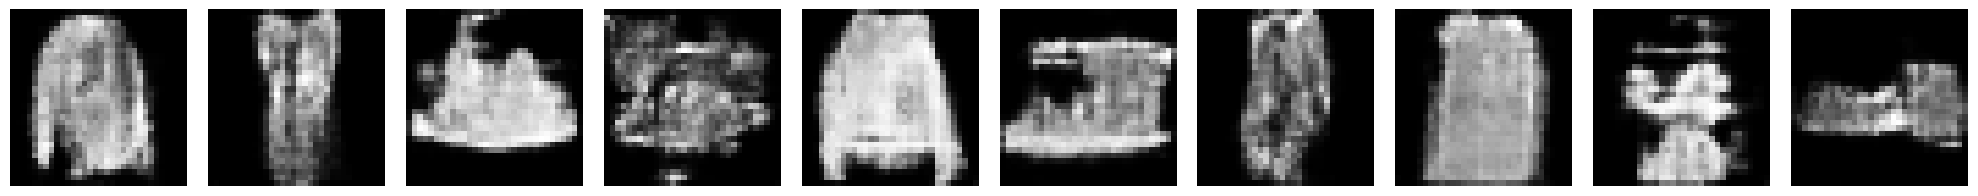

1094/1094 - 59s - 54ms/step - d_loss: 0.4010 - g_loss: 3.0364
Epoch 4/50


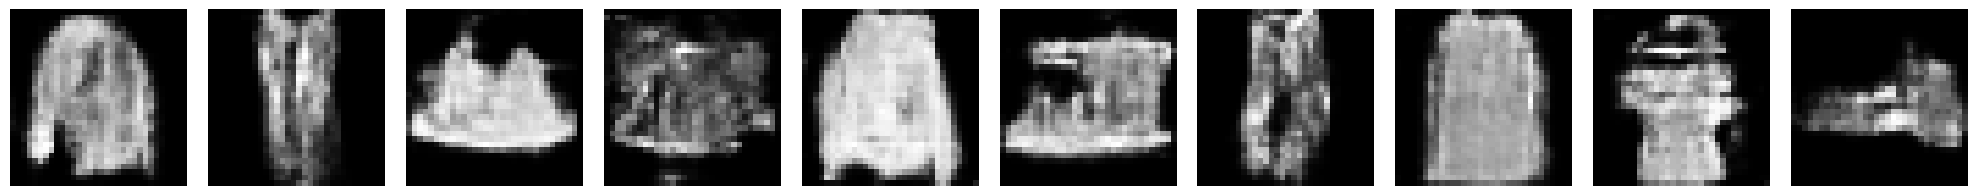

1094/1094 - 84s - 77ms/step - d_loss: 0.4114 - g_loss: 3.0311
Epoch 5/50


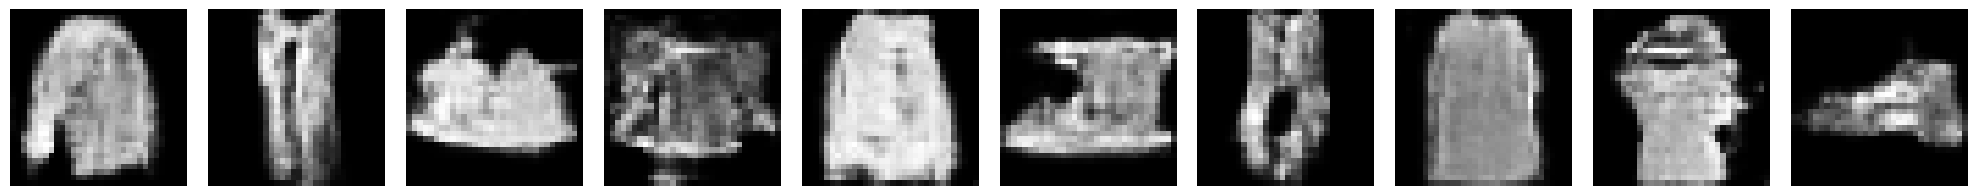

1094/1094 - 84s - 77ms/step - d_loss: 0.4029 - g_loss: 3.1310
Epoch 6/50


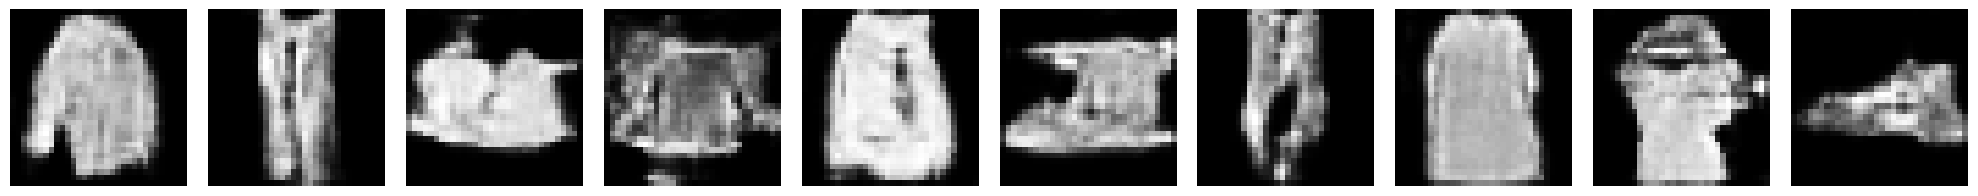

1094/1094 - 59s - 54ms/step - d_loss: 0.3824 - g_loss: 3.3050
Epoch 7/50


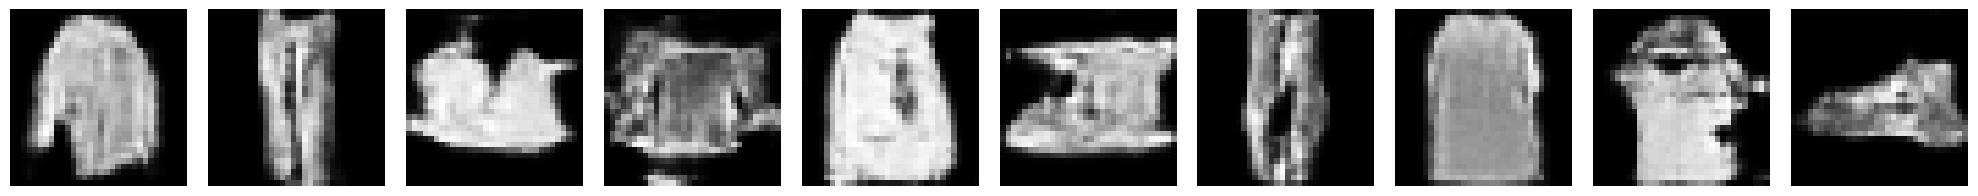

1094/1094 - 85s - 78ms/step - d_loss: 0.3705 - g_loss: 3.4484
Epoch 8/50


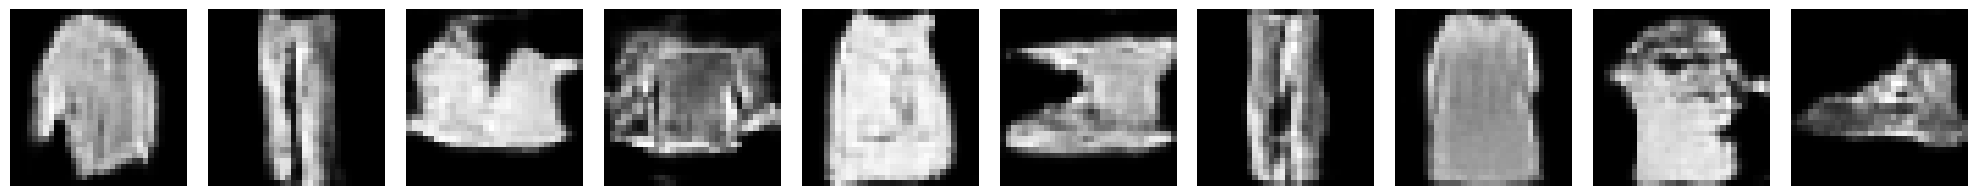

1094/1094 - 84s - 76ms/step - d_loss: 0.3475 - g_loss: 3.6160
Epoch 9/50


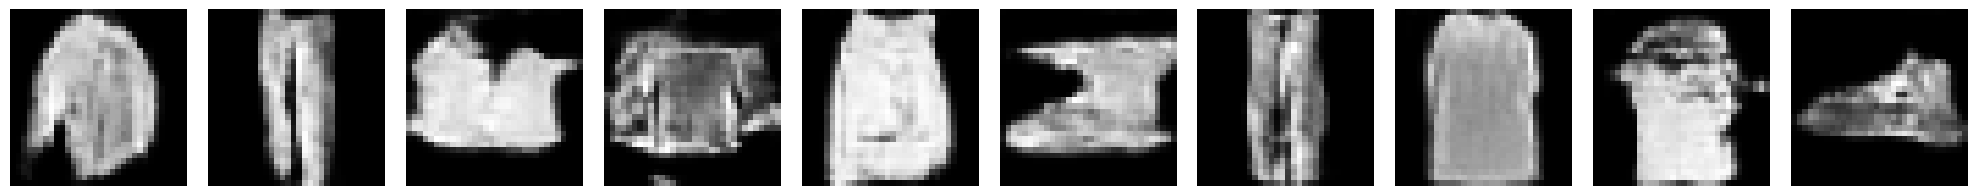

1094/1094 - 84s - 77ms/step - d_loss: 0.3410 - g_loss: 3.7416
Epoch 10/50


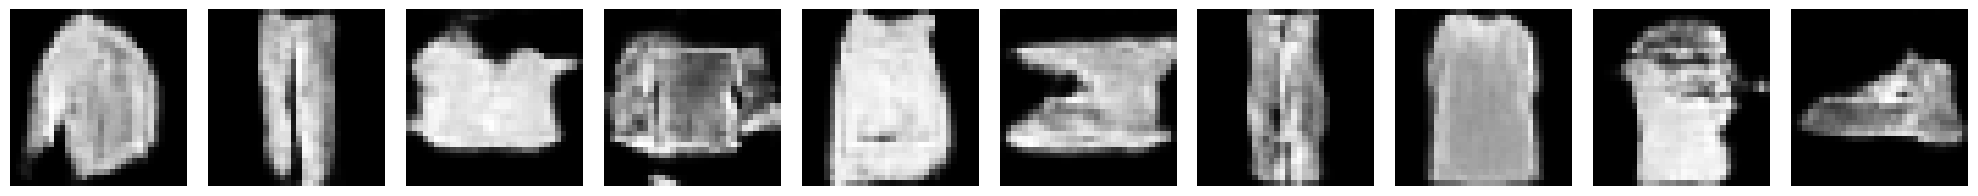

1094/1094 - 83s - 76ms/step - d_loss: 0.3327 - g_loss: 3.8224
Epoch 11/50


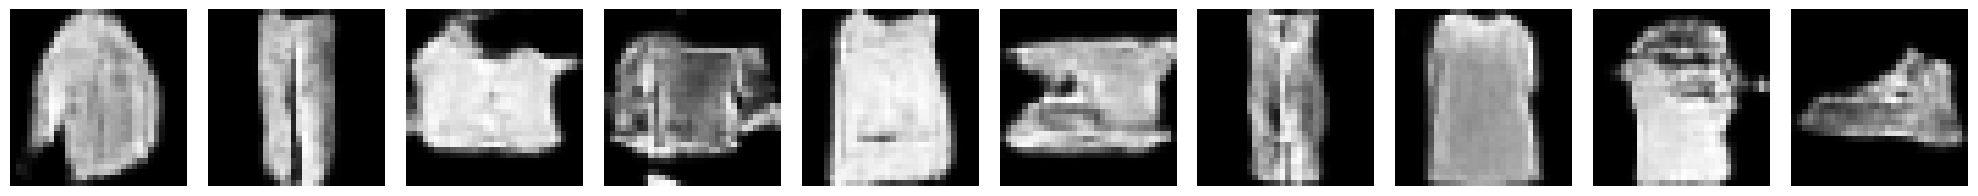

1094/1094 - 84s - 77ms/step - d_loss: 0.3175 - g_loss: 3.9113
Epoch 12/50


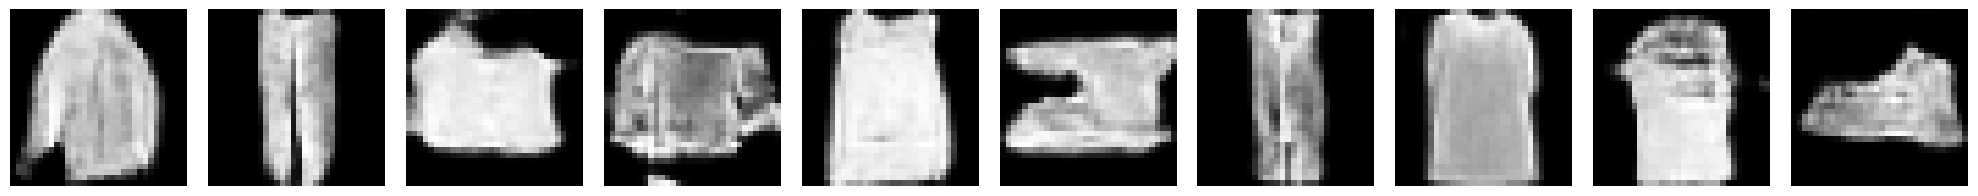

1094/1094 - 84s - 77ms/step - d_loss: 0.3019 - g_loss: 4.1021
Epoch 13/50


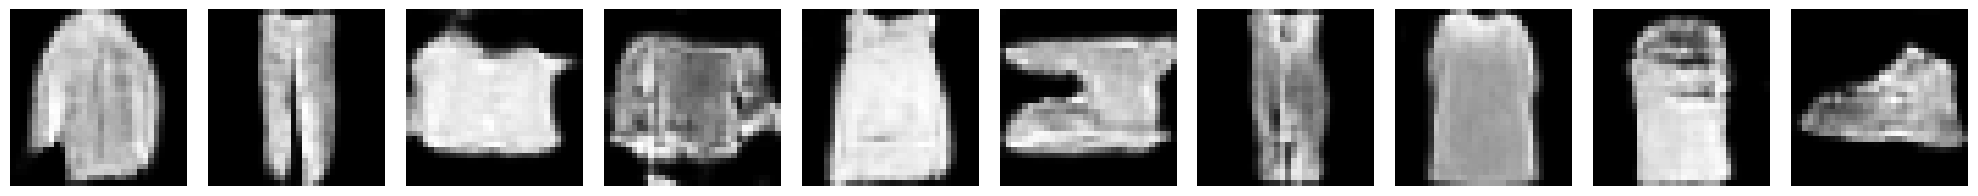

1094/1094 - 60s - 54ms/step - d_loss: 0.2995 - g_loss: 4.1611
Epoch 14/50


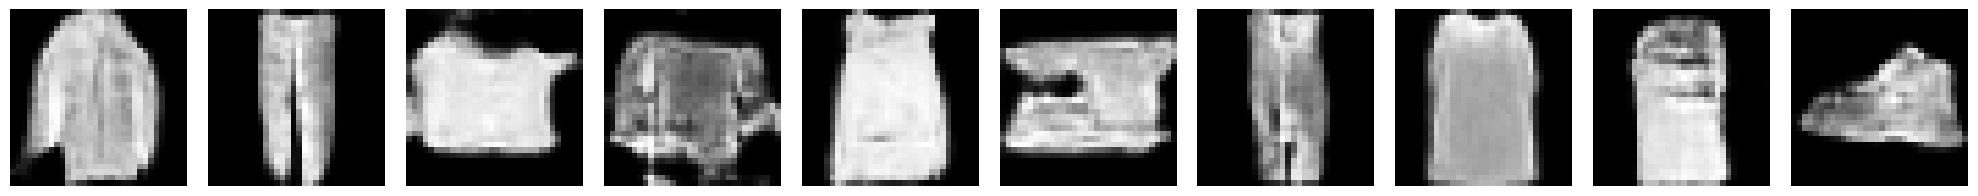

1094/1094 - 84s - 76ms/step - d_loss: 0.2876 - g_loss: 4.3292
Epoch 15/50


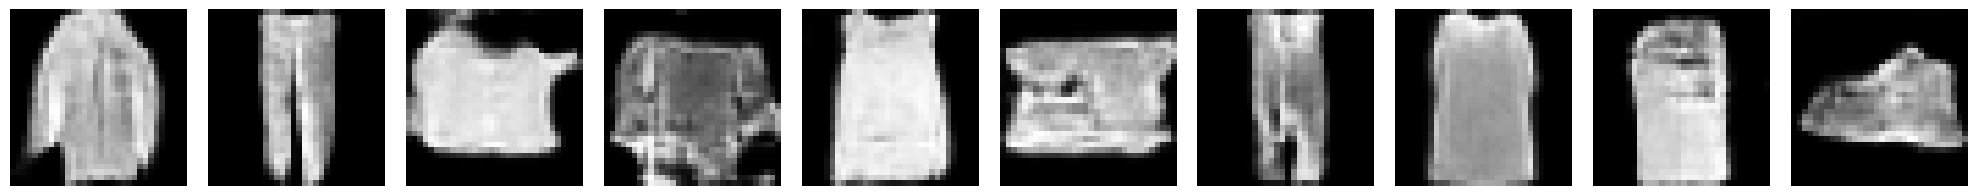

1094/1094 - 85s - 77ms/step - d_loss: 0.2824 - g_loss: 4.4456
Epoch 16/50


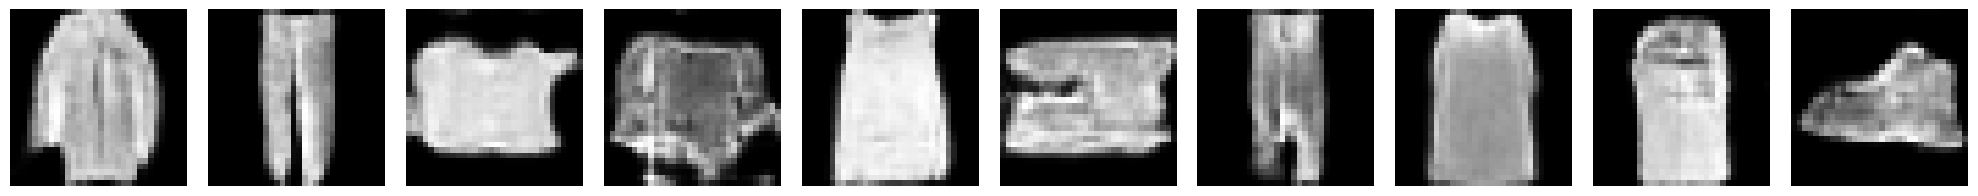

1094/1094 - 83s - 76ms/step - d_loss: 0.2752 - g_loss: 4.5169
Epoch 17/50


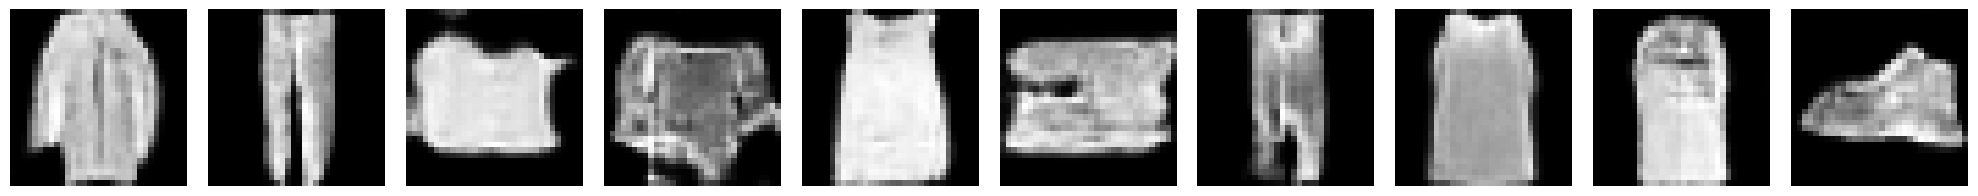

1094/1094 - 84s - 77ms/step - d_loss: 0.2810 - g_loss: 4.5328
Epoch 18/50


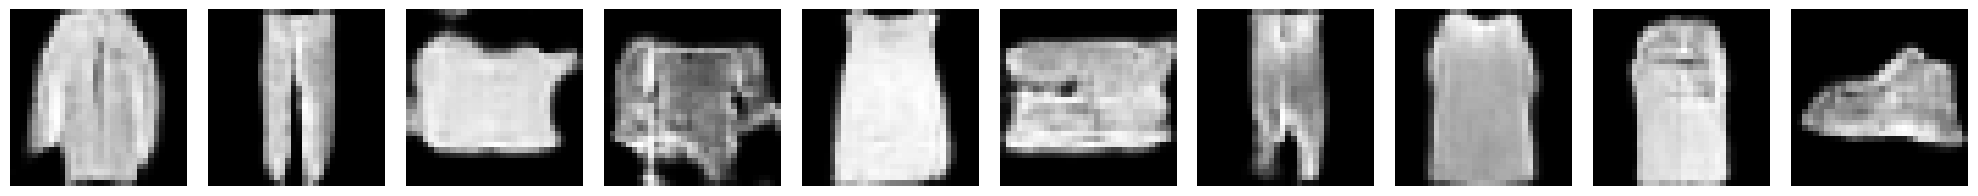

1094/1094 - 59s - 54ms/step - d_loss: 0.2612 - g_loss: 4.6525
Epoch 19/50


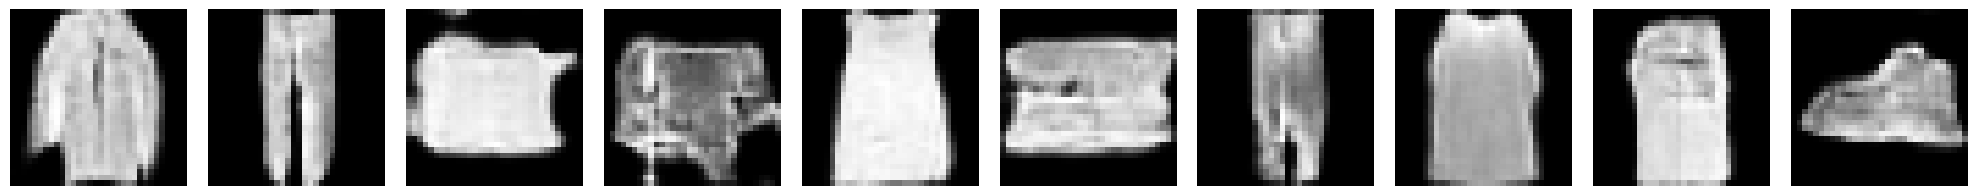

1094/1094 - 84s - 77ms/step - d_loss: 0.2544 - g_loss: 4.7763
Epoch 20/50


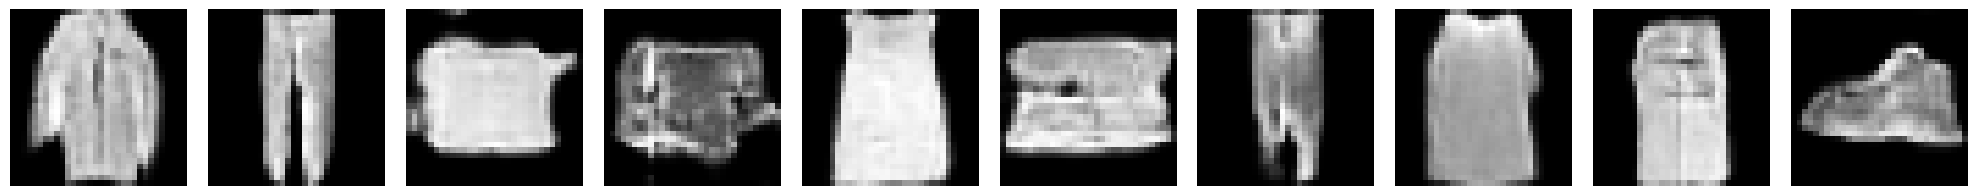

1094/1094 - 59s - 54ms/step - d_loss: 0.2495 - g_loss: 4.8874
Epoch 21/50


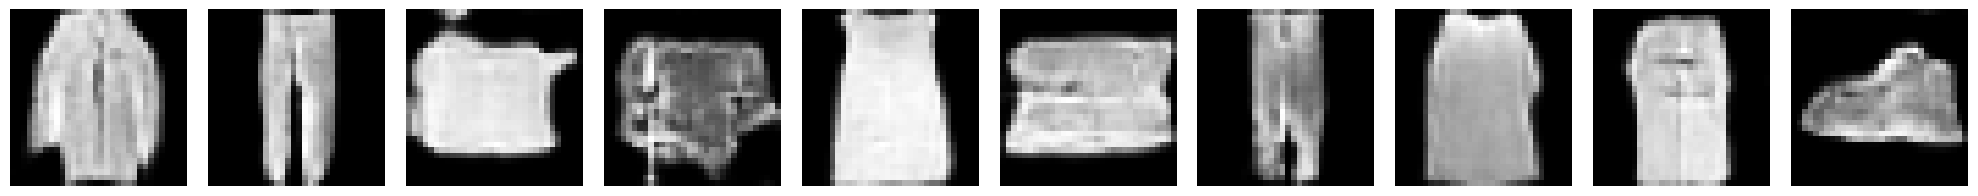

1094/1094 - 84s - 77ms/step - d_loss: 0.2379 - g_loss: 5.0116
Epoch 22/50


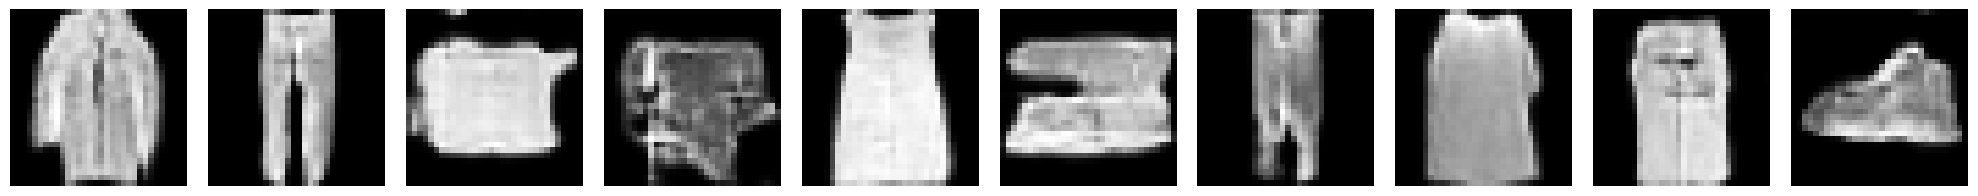

1094/1094 - 59s - 54ms/step - d_loss: 0.2301 - g_loss: 5.0826
Epoch 23/50


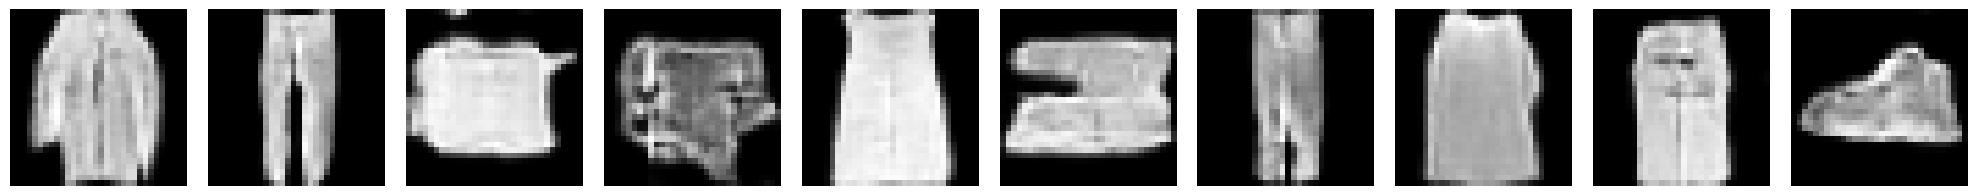

1094/1094 - 85s - 77ms/step - d_loss: 0.2444 - g_loss: 5.0858
Epoch 24/50


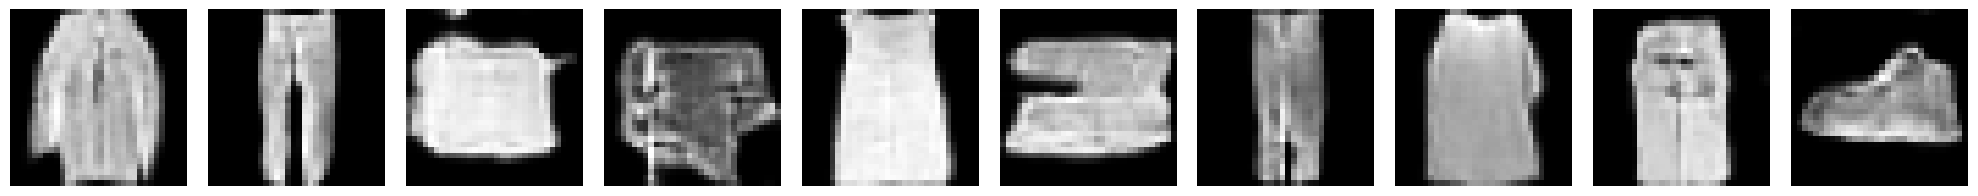

1094/1094 - 59s - 54ms/step - d_loss: 0.2114 - g_loss: 5.2923
Epoch 25/50


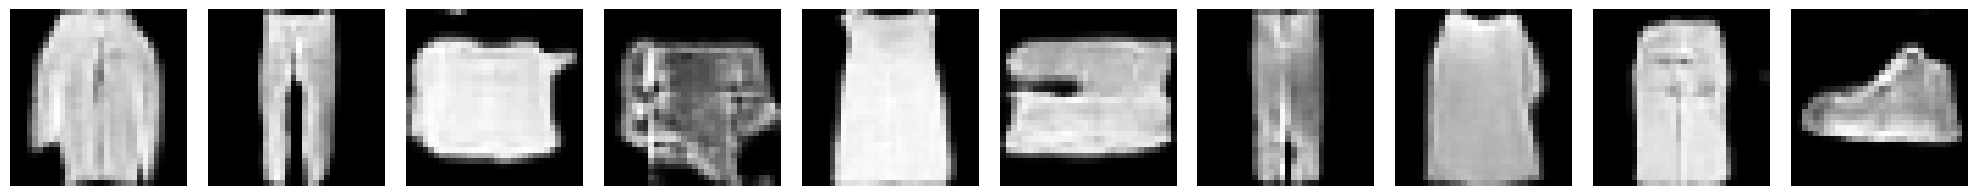

1094/1094 - 86s - 79ms/step - d_loss: 0.2196 - g_loss: 5.3912
Epoch 26/50


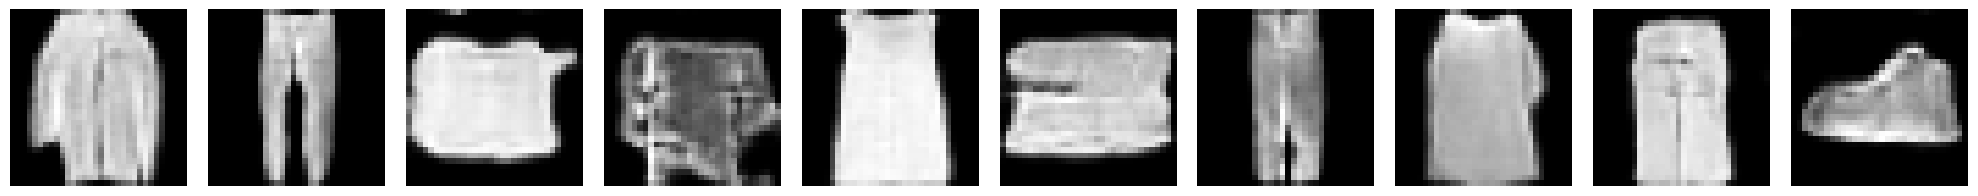

1094/1094 - 84s - 76ms/step - d_loss: 0.2198 - g_loss: 5.3714
Epoch 27/50


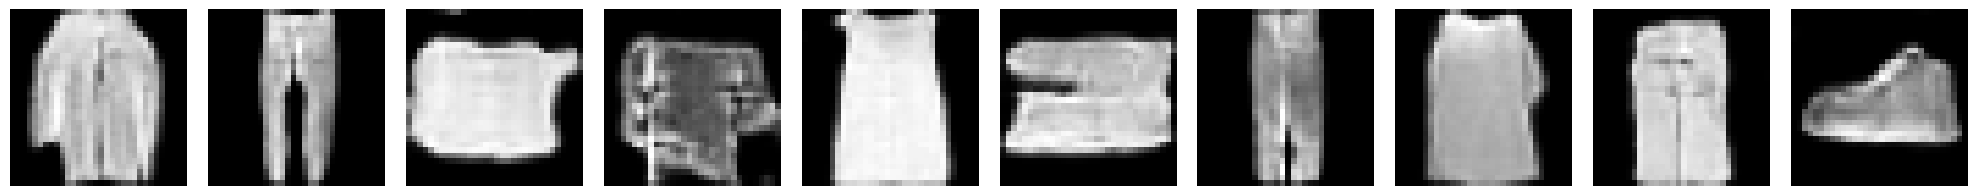

1094/1094 - 84s - 77ms/step - d_loss: 0.2041 - g_loss: 5.5288
Epoch 28/50


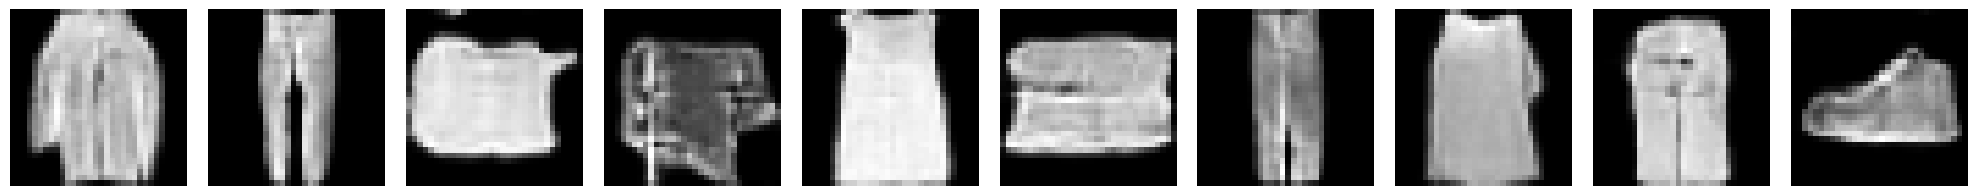

1094/1094 - 59s - 54ms/step - d_loss: 0.2045 - g_loss: 5.6179
Epoch 29/50


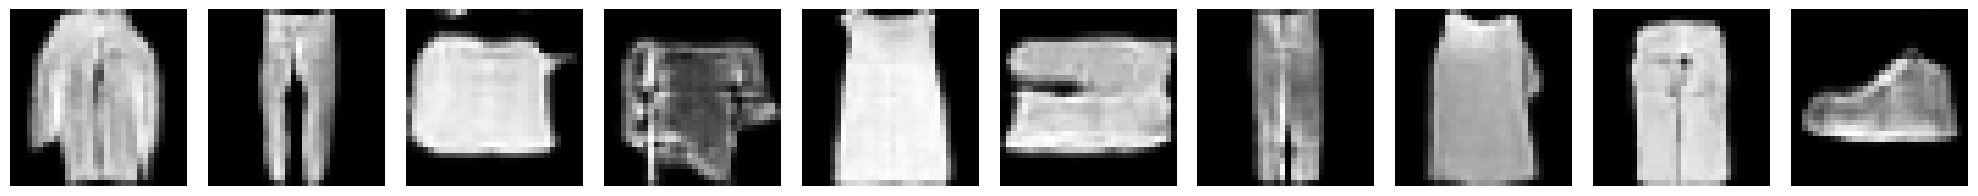

1094/1094 - 60s - 55ms/step - d_loss: 0.2122 - g_loss: 5.6724
Epoch 30/50


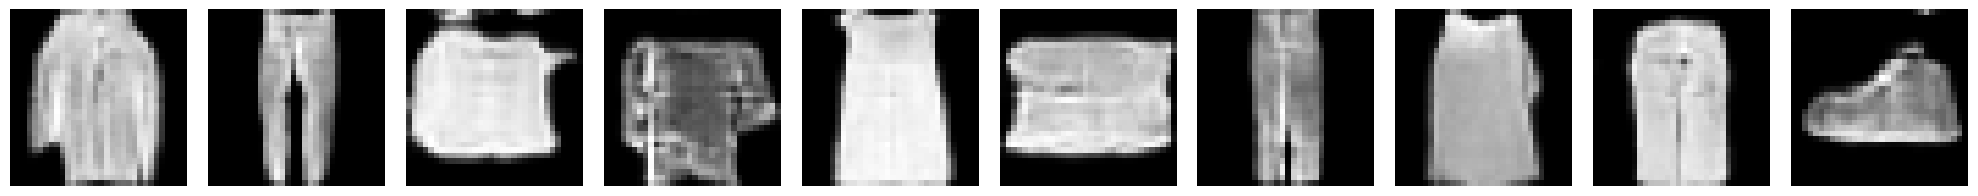

1094/1094 - 84s - 77ms/step - d_loss: 0.1782 - g_loss: 5.8673
Epoch 31/50


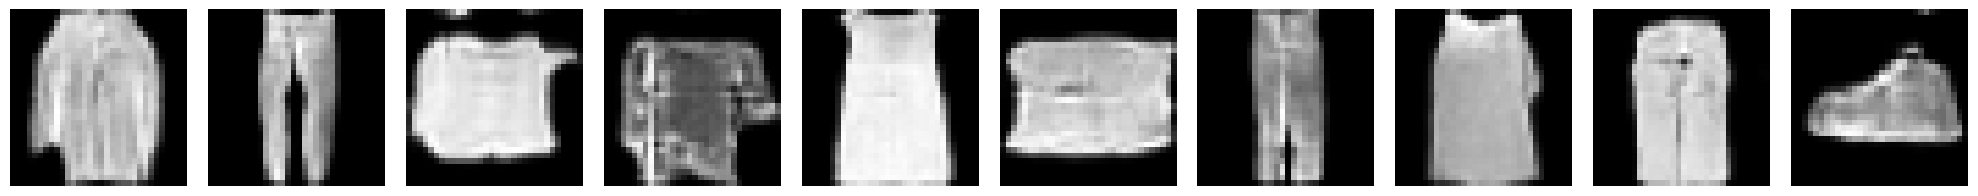

1094/1094 - 84s - 77ms/step - d_loss: 0.1982 - g_loss: 5.8098
Epoch 32/50


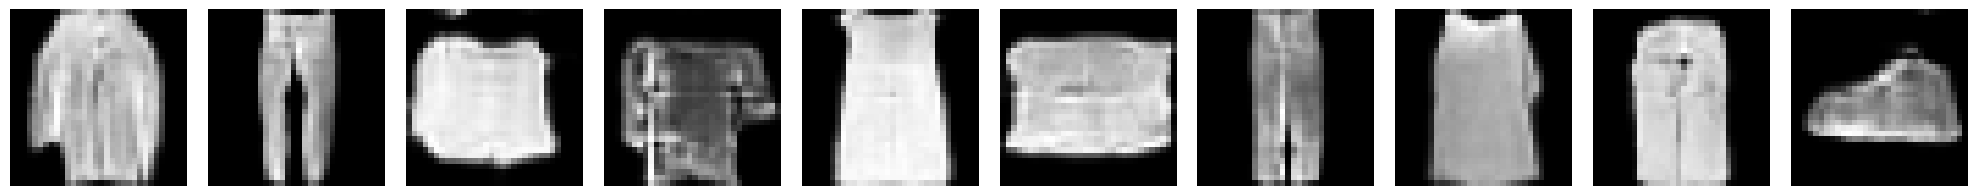

1094/1094 - 83s - 76ms/step - d_loss: 0.1786 - g_loss: 5.9609
Epoch 33/50


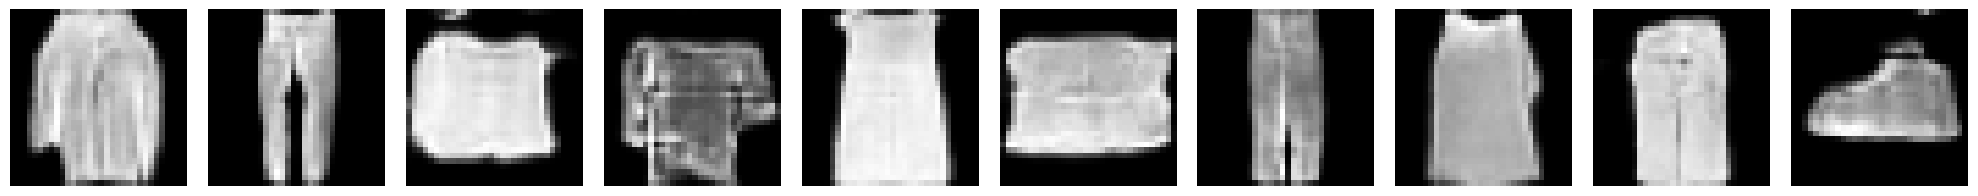

1094/1094 - 84s - 76ms/step - d_loss: 0.1829 - g_loss: 5.9601
Epoch 34/50


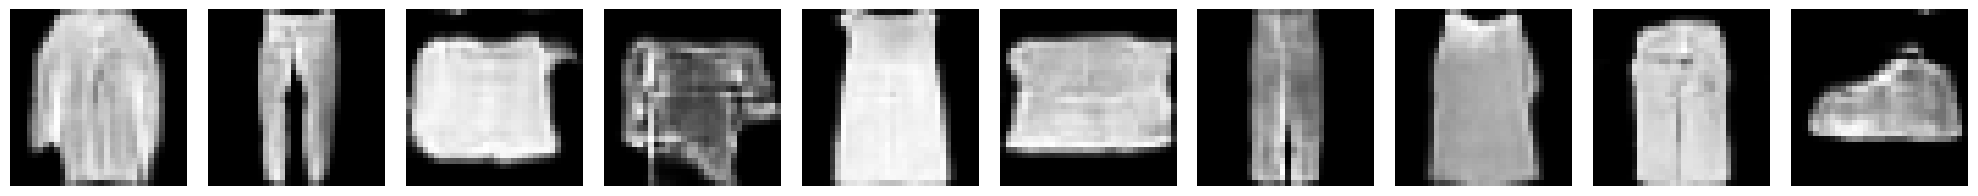

1094/1094 - 84s - 77ms/step - d_loss: 0.1813 - g_loss: 6.0529
Epoch 35/50


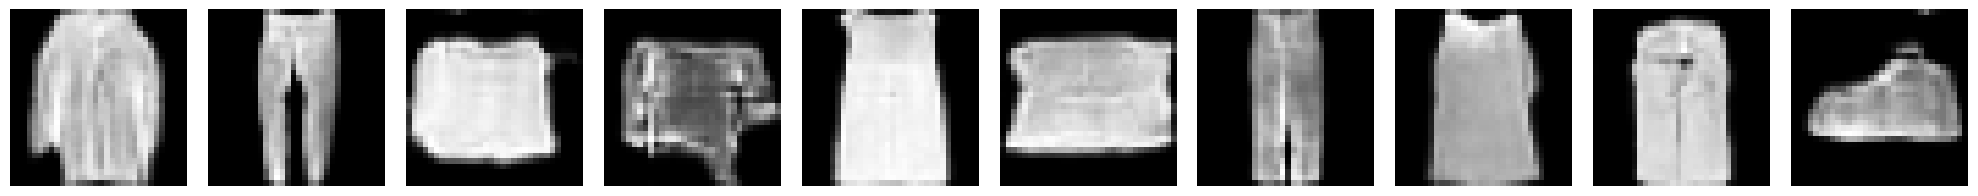

1094/1094 - 84s - 76ms/step - d_loss: 0.1664 - g_loss: 6.2216
Epoch 36/50


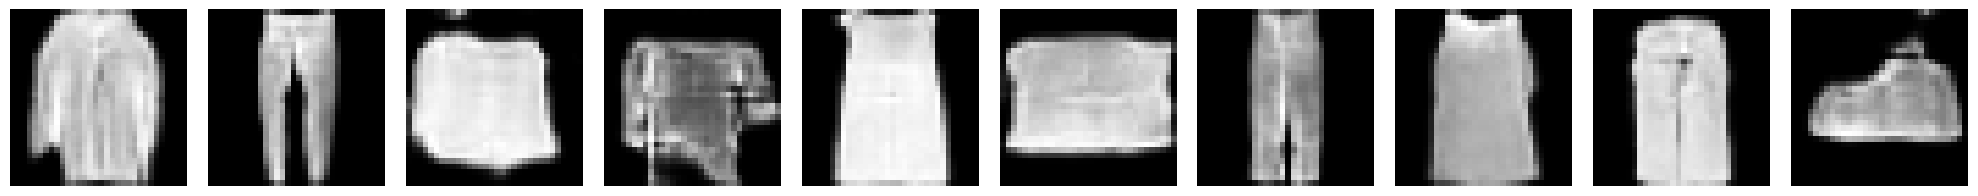

1094/1094 - 58s - 53ms/step - d_loss: 0.1704 - g_loss: 6.1756
Epoch 37/50


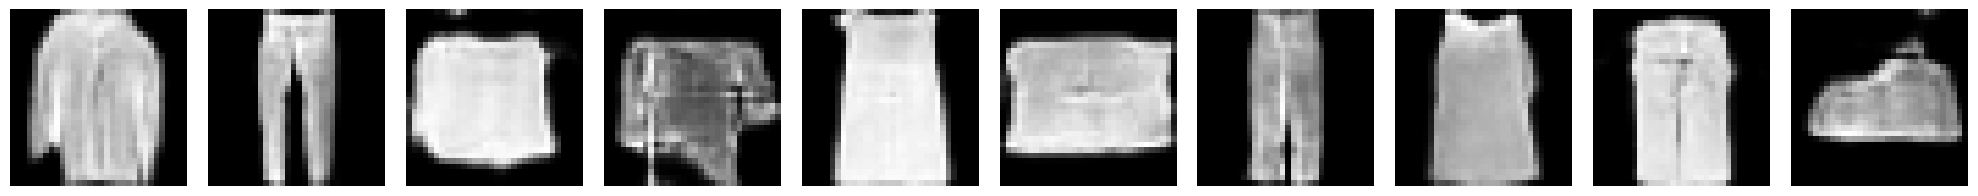

1094/1094 - 59s - 54ms/step - d_loss: 0.1674 - g_loss: 6.2478
Epoch 38/50


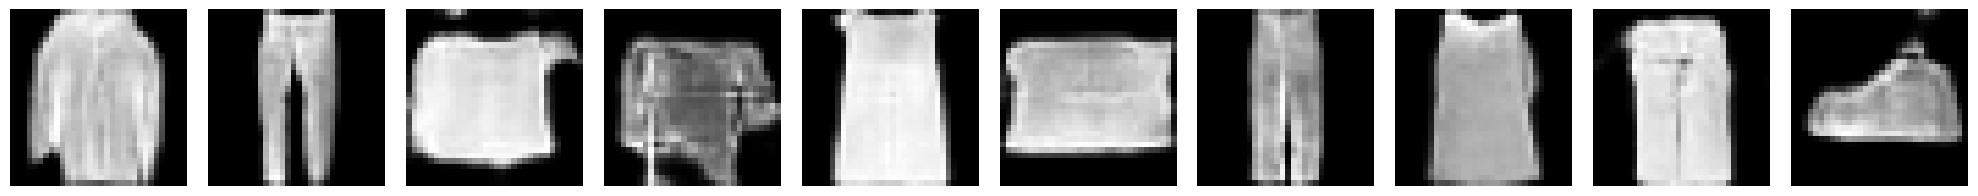

1094/1094 - 84s - 76ms/step - d_loss: 0.1794 - g_loss: 6.2808
Epoch 39/50


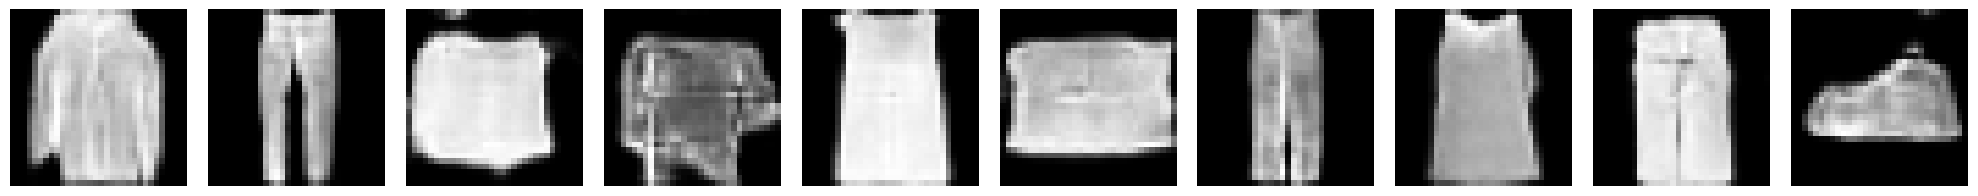

1094/1094 - 58s - 53ms/step - d_loss: 0.1703 - g_loss: 6.3440
Epoch 40/50


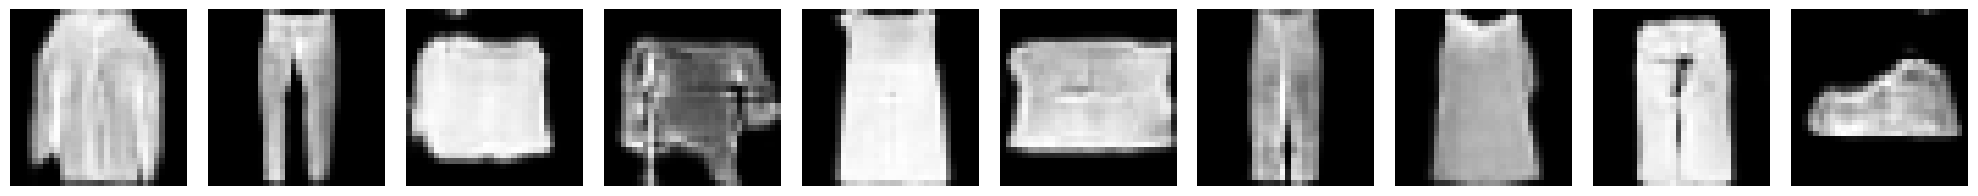

1094/1094 - 85s - 78ms/step - d_loss: 0.1860 - g_loss: 6.3389
Epoch 41/50


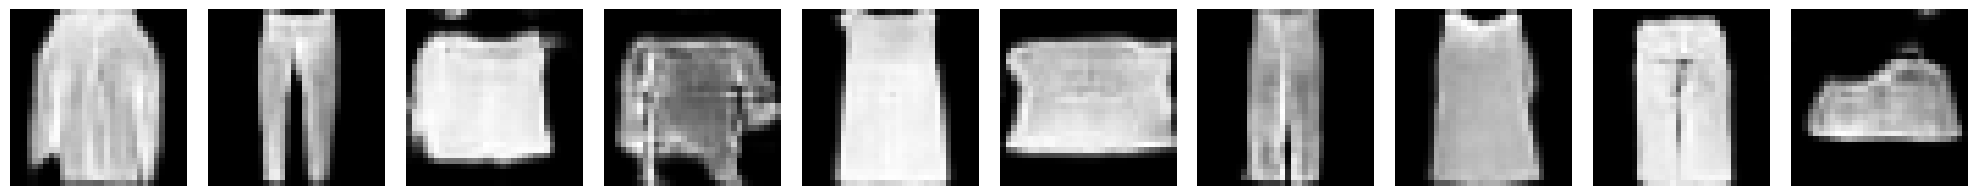

1094/1094 - 58s - 53ms/step - d_loss: 0.1555 - g_loss: 6.4987
Epoch 42/50


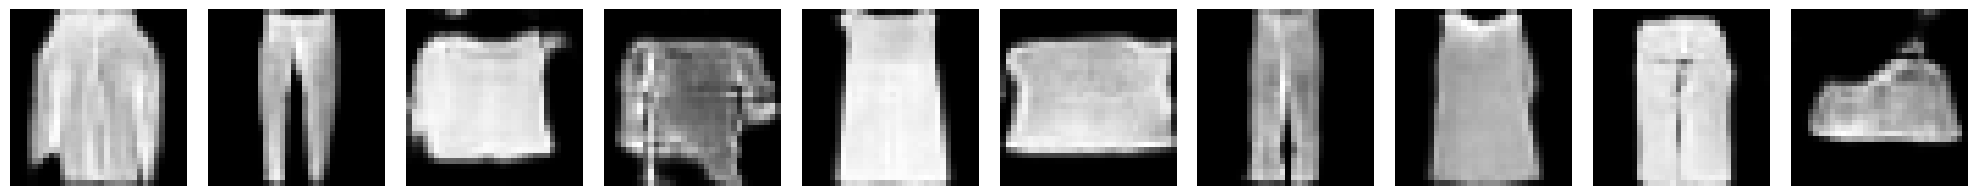

1094/1094 - 84s - 77ms/step - d_loss: 0.1582 - g_loss: 6.5581
Epoch 43/50


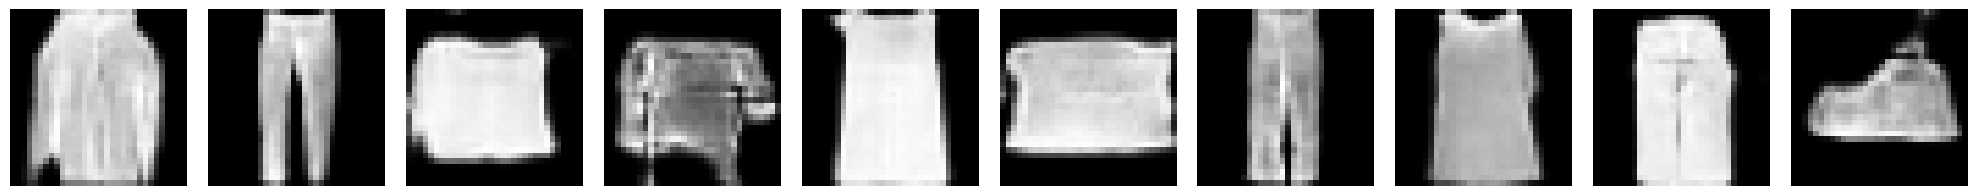

1094/1094 - 83s - 76ms/step - d_loss: 0.1537 - g_loss: 6.5860
Epoch 44/50


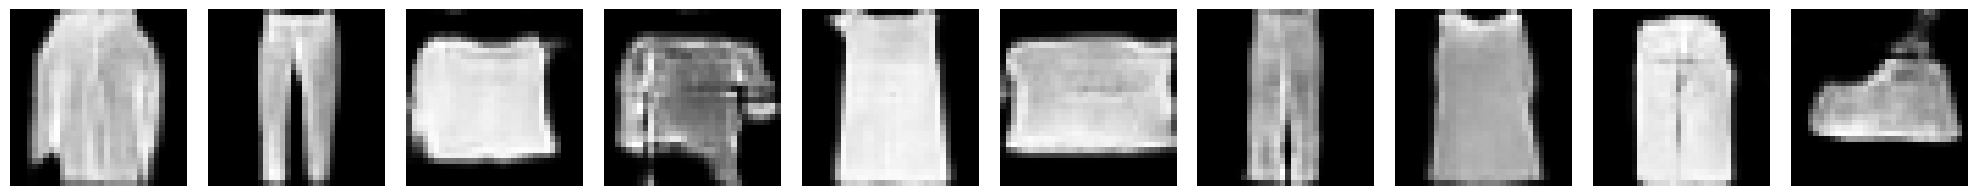

1094/1094 - 58s - 53ms/step - d_loss: 0.1787 - g_loss: 6.4170
Epoch 45/50


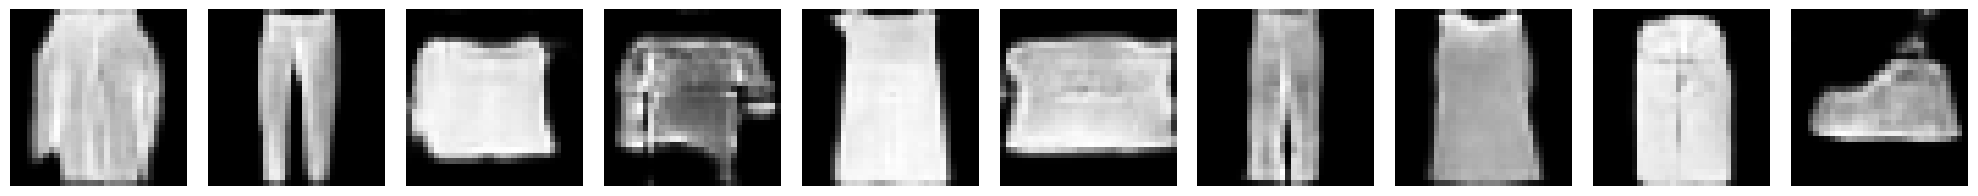

1094/1094 - 59s - 54ms/step - d_loss: 0.1753 - g_loss: 6.4154
Epoch 46/50


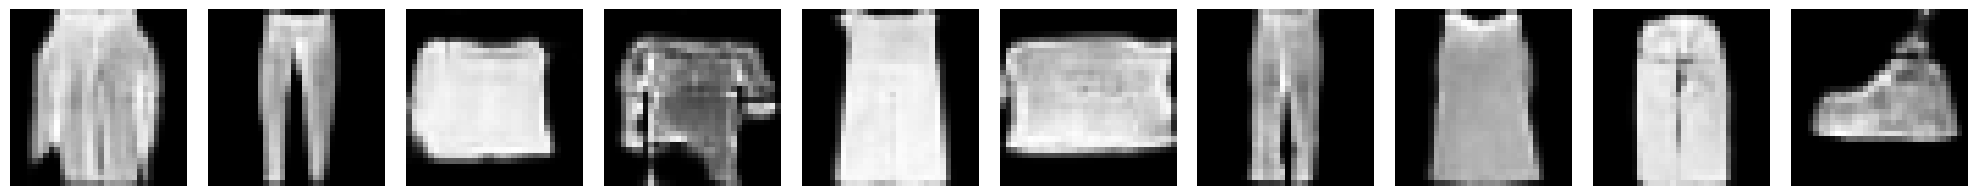

1094/1094 - 60s - 54ms/step - d_loss: 0.1467 - g_loss: 6.6469
Epoch 47/50


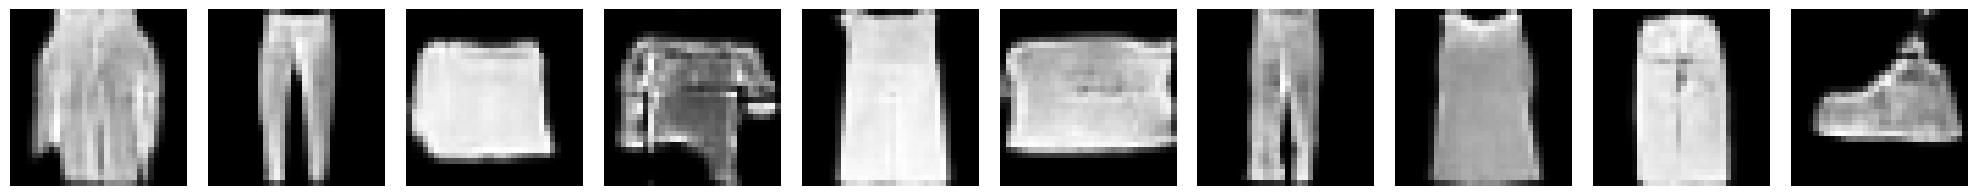

1094/1094 - 84s - 77ms/step - d_loss: 0.1500 - g_loss: 6.6587
Epoch 48/50


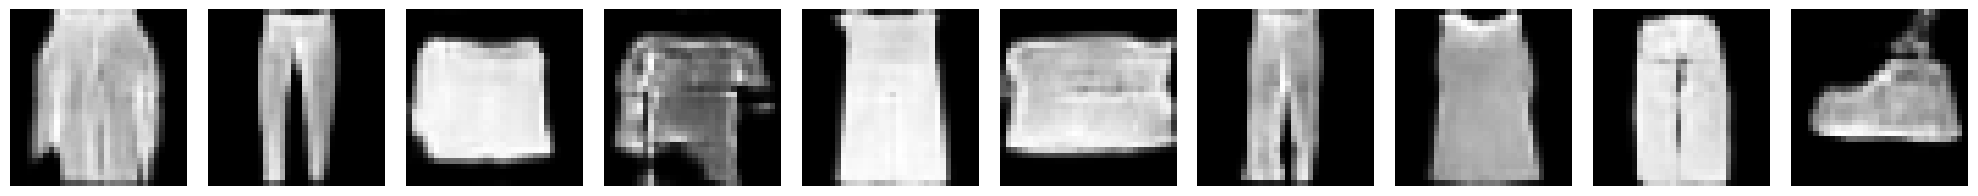

1094/1094 - 58s - 53ms/step - d_loss: 0.1558 - g_loss: 6.7229
Epoch 49/50


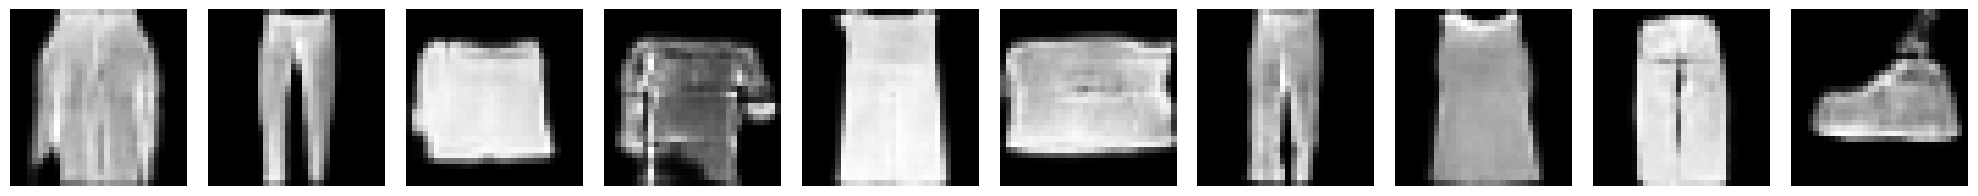

1094/1094 - 59s - 54ms/step - d_loss: 0.1686 - g_loss: 6.5471
Epoch 50/50


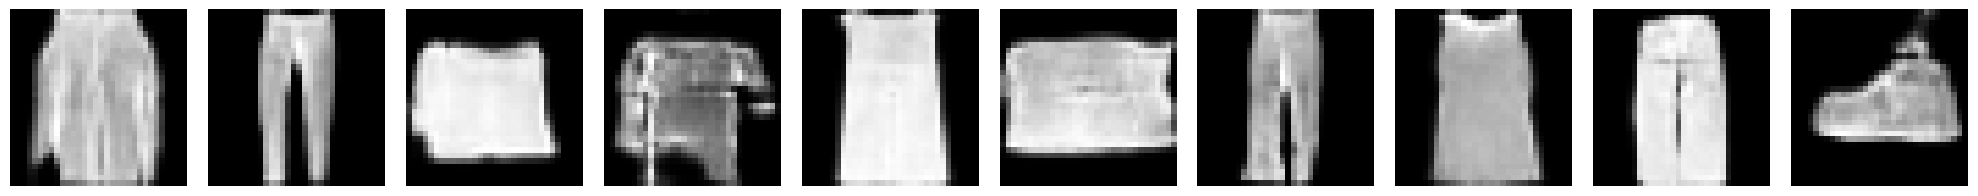

1094/1094 - 84s - 77ms/step - d_loss: 0.1362 - g_loss: 6.8983


In [15]:
# Train the GAN model on the dataset with specified parameters
history = gan.fit(
    X,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[GANMonitor(name='fashionmnist_gan', gray=True)],
    verbose=2
).history

# Save the trained generator model
gan.generator.save('fashionmnist_gan.keras')

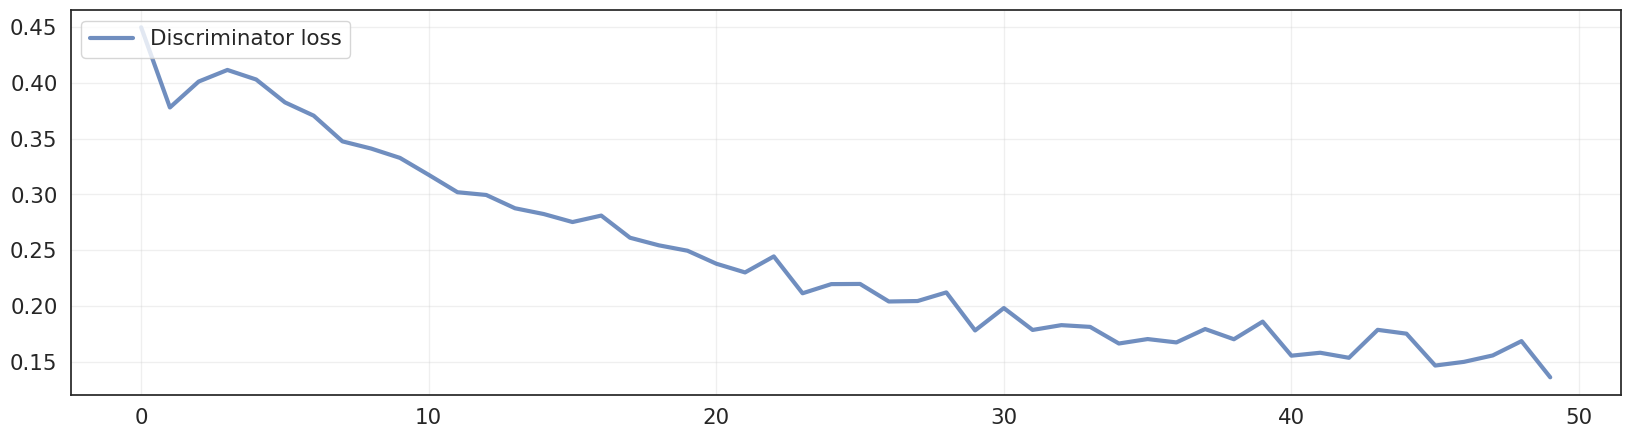

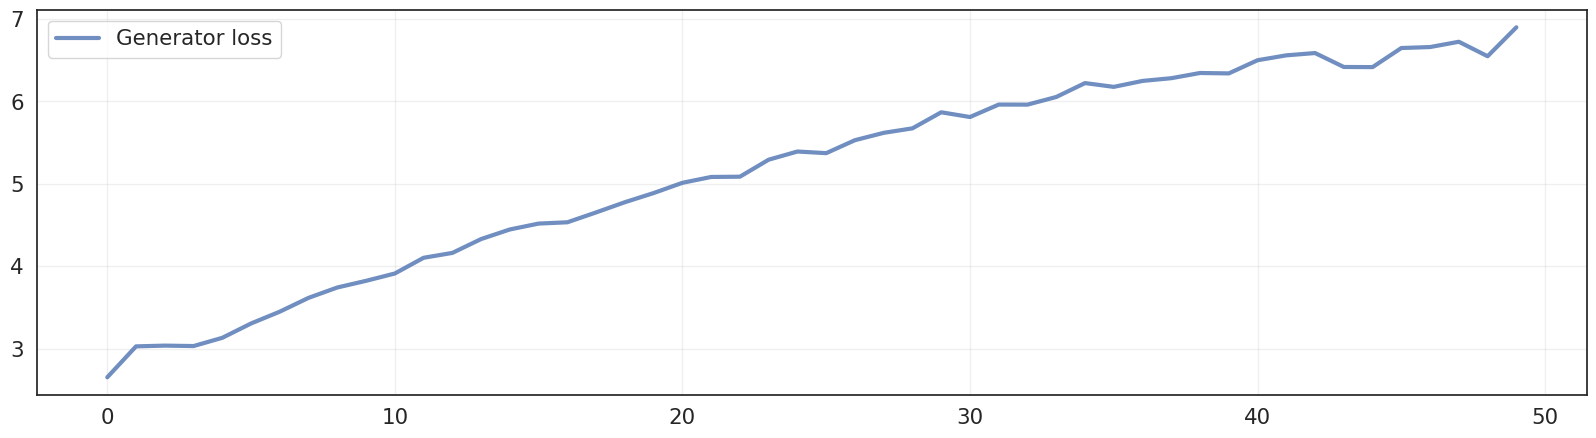

In [16]:
# Plot the discriminator loss during training
plt.figure(figsize=(20, 5))
plt.plot(history['d_loss'], label='Discriminator loss', alpha=0.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

# Plot the generator loss during training
plt.figure(figsize=(20, 5))
plt.plot(history['g_loss'], label='Generator loss', alpha=0.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

# Display the plots
plt.show()

## 🕹️ Use the Model - Make Inference

In [17]:
# Load the saved GAN generator model
gan_generator = tfk.models.load_model('fashionmnist_gan.keras')

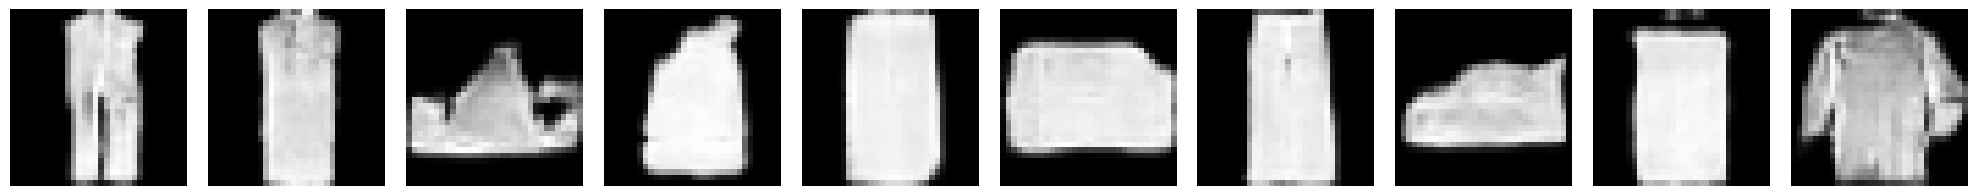

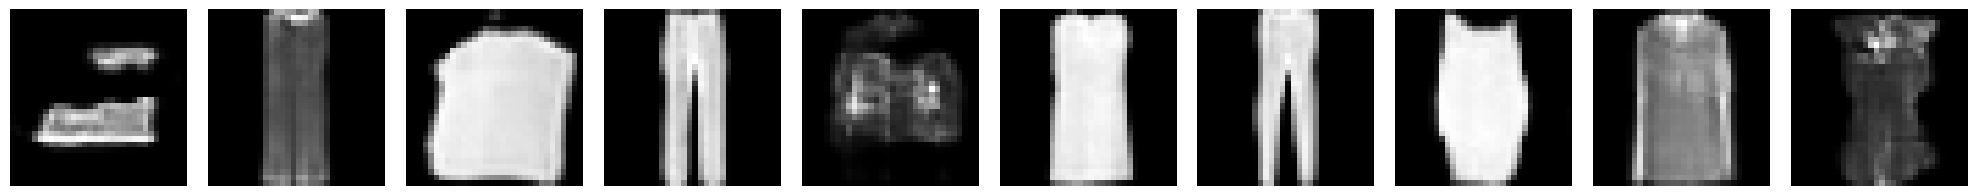

In [18]:
# Generate and display 10 grayscale sample images using the loaded GAN generator
# Disable fixed random seed for both invocations
sample(gan_generator, 10, latent_dim, fixed=False, gray=True)
sample(gan_generator, 10, latent_dim, fixed=False, gray=True)

## 🛠️ Conditional Generative Adversarial Network (cGAN)

**Variables and Parameters**

$D$: Discriminator network (outputs probability between 0 and 1)  
$G$: Generator network (creates synthetic samples)  
$x$: Input data samples  
$y$: Conditional information (e.g., class labels, auxiliary data)  
$p_r(x|y)$: Conditional probability distribution of real data samples  
$p_g(x|y)$: Conditional probability distribution of generated samples  
$L(G,D)$: Loss function to be optimized  
$\mathbb{E}$: Expected value operator  

**Formula**

$$
\min_{G} \max_{D} L(G,D) = \mathbb{E}_{x \sim p_r(x|y)}[\log(D(x|y))] + \mathbb{E}_{x \sim p_g(x|y)}[\log(1-D(x|y))]
$$

**Description**

The conditional GAN extends the traditional GAN framework by incorporating additional information ($y$) to guide both generation and discrimination processes. In this formulation, both networks operate with awareness of specified conditions, enabling more controlled generation of synthetic data.

The discriminator network now evaluates samples while considering the given condition, determining whether a sample is authentic for its specific condition. Meanwhile, the generator creates samples that must align with the provided conditional information, attempting to match the real data distribution for each condition.

At theoretical equilibrium, the generator produces samples matching the real data distribution for each condition, while the discriminator's predictions approach 0.5 for both real and generated samples within their respective conditions. This means $p_g(x|y)$ should converge to $p_r(x|y)$ across all valid conditions $y$.

This mathematical framework enables precise control over the generation process while maintaining the adversarial training dynamics that make GANs effective for synthetic data generation.

In [19]:
# Define a function to create a conditional discriminator model
def get_conditional_discriminator(input_shape=input_shape, num_classes=num_classes, seed=seed):
    # Set random seed for reproducibility
    tf.random.set_seed(seed)

    # Define input layers for the image and conditioning label
    input_layer_image = tfkl.Input(shape=input_shape, name='input_layer_image')
    input_layer_conditioning = tfkl.Input(shape=(1,), name='input_layer_conditioning')

    # Embed and process the conditioning input
    x_c = tfkl.Embedding(num_classes, input_shape[0] * input_shape[1], name='embedding')(input_layer_conditioning)
    x_c = tfkl.Flatten(name='flatten')(x_c)
    x_c = tfkl.Reshape((input_shape[0], input_shape[1], 1))(x_c)

    # Concatenate the conditioning information with the image input
    x = tfkl.Concatenate(axis=-1)([input_layer_image, x_c])

    # First convolutional block
    x = tfkl.Conv2D(32, 4, padding='same', strides=2, name='conv1')(x)
    x = tfkl.LayerNormalization(name='ln1')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(x)

    # Second convolutional block
    x = tfkl.Conv2D(64, 4, padding='same', strides=2, name='conv2')(x)
    x = tfkl.LayerNormalization(name='ln2')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(x)

    # Third convolutional block
    x = tfkl.Conv2D(128, 4, padding='same', strides=2, name='conv3')(x)
    x = tfkl.LayerNormalization(name='ln3')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation3')(x)

    # Final classification block
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    x = tfkl.Dense(256, name='dense1')(x)
    x = tfkl.LayerNormalization(name='ln4')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation4')(x)
    output_layer = tfkl.Dense(1, name='dense_out')(x)

    # Create and return the conditional discriminator model
    return tf.keras.Model(
        inputs=[input_layer_image, input_layer_conditioning],
        outputs=output_layer,
        name='conditional_discriminator'
    )

Model: "conditional_discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_condition… │ (None, 1)            │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ embedding (Embedding)  │ (None, 1, 1024)      │       10,240 │ input_layer_condit… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ flatten (Flatten)      │ (None, 1024)         │            0 │ embedding[0][0]     │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ input_layer_image      │ (None, 32, 32, 1)    │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ reshape_2 (Reshape)    │ (None, 32, 32, 1)    │            0 │ flatten[0][0]       │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ concatenate            │ (None, 32, 32, 2)    │            0 │ input_layer_image[… │    -    │
│ (Concatenate)          │                      │              │ reshape_2[0][0]     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1 (Conv2D)         │ (None, 16, 16, 32)   │        1,056 │ concatenate[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ ln1                    │ (None, 16, 16, 32)   │           64 │ conv1[0][0]         │    Y    │
│ (LayerNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation1            │ (None, 16, 16, 32)   │            0 │ ln1[0][0]           │    -    │
│ (LeakyReLU)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2 (Conv2D)         │ (None, 8, 8, 64)     │       32,832 │ activation1[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ ln2                    │ (None, 8, 8, 64)     │          128 │ conv2[0][0]         │    Y    │
│ (LayerNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation2            │ (None, 8, 8, 64)     │            0 │ ln2[0][0]           │    -    │
│ (LeakyReLU)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv3 (Conv2D)         │ (None, 4, 4, 128)    │      131,200 │ activation2[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ ln3                    │ (None, 4, 4, 128)    │          256 │ conv3[0][0]         │    Y    │
│ (LayerNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation3            │ (None, 4, 4, 128)    │            0 │ ln3[0][0]           │    -    │
│ (LeakyReLU)            │                      │              │                     │         │
├──────────────────────

 Total params: 209,569 (818.63 KB)

 Trainable params: 209,569 (818.63 KB)

 Non-trainable params: 0 (0.00 B)

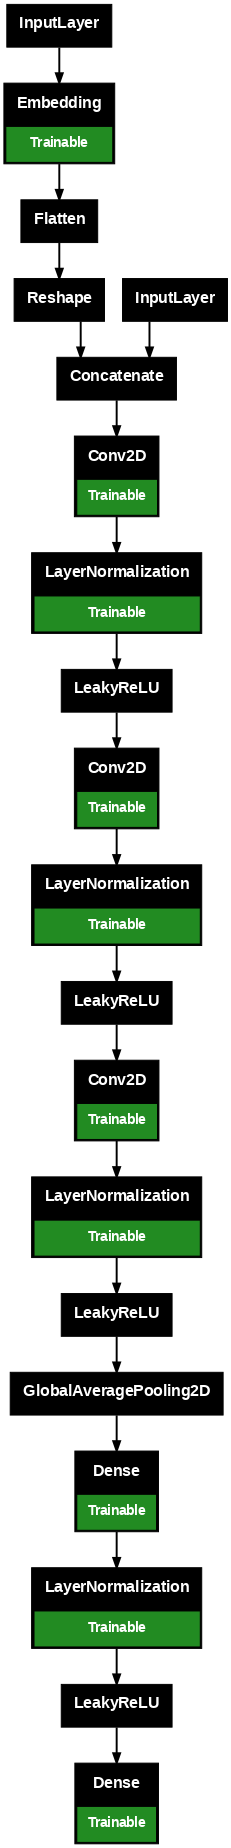

In [20]:
# Instantiate the conditional discriminator model
conditional_discriminator = get_conditional_discriminator()

# Print a detailed summary of the conditional discriminator
conditional_discriminator.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the conditional discriminator architecture
tf.keras.utils.plot_model(
    conditional_discriminator,
    show_trainable=True,
    expand_nested=True,
    dpi=70
)

In [21]:
# Define a function to create a conditional generator model
def get_conditional_generator(input_shape=(latent_dim,), num_classes=num_classes, seed=seed):
    # Set random seed for reproducibility
    tf.random.set_seed(seed)

    # Define input layers for noise vector and conditioning label
    input_layer_noise = tfkl.Input(shape=input_shape, name='input_layer_noise')
    input_layer_conditioning = tfkl.Input(shape=(1,), name='input_layer_conditioning')

    # Embed and process the conditioning input
    x_c = tfkl.Embedding(num_classes, 32, name='embedding')(input_layer_conditioning)
    x_c = tfkl.Flatten(name='flatten')(x_c)

    # Concatenate noise vector and label embedding
    x = tfkl.Concatenate(axis=-1)([input_layer_noise, x_c])

    # Build the generator network
    x = tfkl.Dense(4 * 4 * 64, use_bias=False, name='dense0')(x)
    x = tfkl.LayerNormalization(name='ln0')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation0')(x)
    x = tfkl.Reshape((4, 4, 64))(x)

    x = tfkl.UpSampling2D(name='upsampling1')(x)
    x = tfkl.Conv2D(64, 3, padding='same', use_bias=False, name='conv1')(x)
    x = tfkl.LayerNormalization(name='ln1')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(x)

    x = tfkl.UpSampling2D(name='upsampling2')(x)
    x = tfkl.Conv2D(128, 3, padding='same', use_bias=False, name='conv2')(x)
    x = tfkl.LayerNormalization(name='ln2')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(x)

    x = tfkl.UpSampling2D(name='upsampling3')(x)
    x = tfkl.Conv2D(256, 3, padding='same', use_bias=False, name='conv3')(x)
    x = tfkl.LayerNormalization(name='ln3')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation3')(x)

    x = tfkl.Conv2D(1, 3, padding='same', use_bias=False, name='conv_out')(x)
    output_layer = tfkl.Activation('tanh', name='activation_out')(x)

    # Create and return the conditional generator model
    return tf.keras.Model(
        inputs=[input_layer_noise, input_layer_conditioning],
        outputs=output_layer,
        name='conditional_generator'
    )

Model: "conditional_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_condition… │ (None, 1)            │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ embedding (Embedding)  │ (None, 1, 32)        │          320 │ input_layer_condit… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ input_layer_noise      │ (None, 64)           │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ flatten (Flatten)      │ (None, 32)           │            0 │ embedding[0][0]     │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ concatenate_1          │ (None, 96)           │            0 │ input_layer_noise[… │    -    │
│ (Concatenate)          │                      │              │ flatten[0][0]       │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense0 (Dense)         │ (None, 1024)         │       98,304 │ concatenate_1[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ ln0                    │ (None, 1024)         │        2,048 │ dense0[0][0]        │    Y    │
│ (LayerNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation0            │ (None, 1024)         │            0 │ ln0[0][0]           │    -    │
│ (LeakyReLU)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ reshape_3 (Reshape)    │ (None, 4, 4, 64)     │            0 │ activation0[0][0]   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ upsampling1            │ (None, 8, 8, 64)     │            0 │ reshape_3[0][0]     │    -    │
│ (UpSampling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1 (Conv2D)         │ (None, 8, 8, 64)     │       36,864 │ upsampling1[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ ln1                    │ (None, 8, 8, 64)     │          128 │ conv1[0][0]         │    Y    │
│ (LayerNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation1            │ (None, 8, 8, 64)     │            0 │ ln1[0][0]           │    -    │
│ (LeakyReLU)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ upsampling2            │ (None, 16, 16, 64)   │            0 │ activation1[0][0]   │    -    │
│ (UpSampling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2 (Conv2D)         │ (None, 16, 16, 128)  │       73,728 │ upsampling2[0][0]   │    Y    │
├──────────────────────

 Total params: 509,376 (1.94 MB)

 Trainable params: 509,376 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

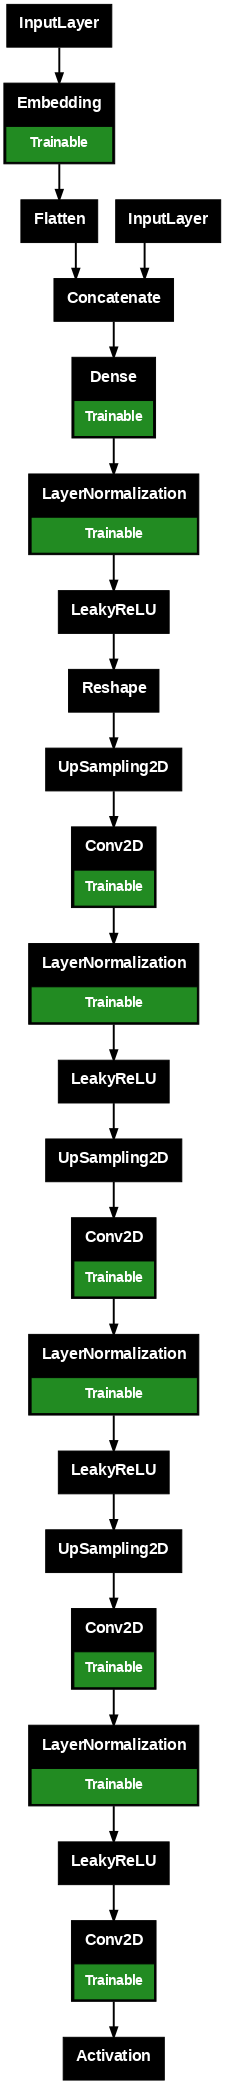

In [22]:
# Instantiate the conditional generator model
conditional_generator = get_conditional_generator()

# Print a detailed summary of the conditional generator
conditional_generator.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the conditional generator architecture
tf.keras.utils.plot_model(
    conditional_generator,
    show_trainable=True,
    expand_nested=True,
    dpi=70
)

In [23]:
# Define a conditional GAN (cGAN) class inheriting from tf.keras.Model
class cGAN(tfk.Model):

    # Initialise the cGAN with a discriminator, generator, latent dimension, and discriminator update frequency
    def __init__(self, discriminator, generator, latent_dim, n_discriminator_updates=3):
        super(cGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.n_discriminator_updates = n_discriminator_updates

        # Initialise loss trackers for discriminator and generator
        self.d_loss_tracker = tfk.metrics.Mean(name="d_loss")
        self.g_loss_tracker = tfk.metrics.Mean(name="g_loss")

    # Compile the cGAN with optimisers and an optional loss function
    def compile(self, d_optimizer, g_optimizer, loss_fn=None):
        super(cGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn or tfk.losses.BinaryCrossentropy(from_logits=True)

    # Define cGAN metrics
    @property
    def metrics(self):
        return [self.d_loss_tracker, self.g_loss_tracker]

    # Compute generator loss
    def _generator_loss(self, fake_output):
        return self.loss_fn(tf.ones_like(fake_output), fake_output)

    # Compute discriminator loss
    def _discriminator_loss(self, real_output, fake_output):
        real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
        fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    # Define the training step
    @tf.function
    def train_step(self, data):
        # Unpack the data into images and labels
        real_images, class_labels = data
        batch_size = tf.shape(real_images)[0]

        # Train discriminator multiple times
        d_loss = 0
        for _ in range(self.n_discriminator_updates):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                # Generate fake images
                generated_images = self.generator([random_latent_vectors, class_labels], training=True)

                # Get discriminator outputs for real and fake images
                real_output = self.discriminator([real_images, class_labels], training=True)
                fake_output = self.discriminator([generated_images, class_labels], training=True)

                # Calculate discriminator loss
                current_d_loss = self._discriminator_loss(real_output, fake_output)

            # Apply discriminator gradients
            grads = tape.gradient(current_d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
            d_loss += current_d_loss / self.n_discriminator_updates

        # Train generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator([random_latent_vectors, class_labels], training=True)

            # Get discriminator output for fake images
            fake_output = self.discriminator([generated_images, class_labels], training=False)

            # Calculate generator loss
            g_loss = self._generator_loss(fake_output)

        # Apply generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update loss trackers
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)

        # Return loss metrics
        return {
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result()
        }

In [24]:
# Define a callback for monitoring conditional GAN training progress
class ConditionalGANMonitor(tfk.callbacks.Callback):

    # Initialise the callback with the number of images, classes, latent dimension, and display options
    def __init__(self, num_img=10, num_classes=10, latent_dim=latent_dim, name='', gray=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.name = name
        self.gray = gray

    # Generate and display images at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        # Set random seed for reproducibility
        tf.random.set_seed(seed)

        # Ensure output directory exists
        os.makedirs(self.name + 'temp', exist_ok=True)

        # Generate random latent vectors and class labels
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        labels = tf.cast(tf.math.floormod(tf.range(0, self.num_img), self.num_classes), 'float32')

        # Generate images using the model's generator
        generated_images = self.model.generator([random_latent_vectors, labels]).numpy()

        # Plot the generated images
        fig, axes = plt.subplots(1, self.num_img, figsize=(20, 2 * self.num_img))
        for i in range(self.num_img):
            img = tfk.preprocessing.image.array_to_img(generated_images[i])
            ax = axes[i % self.num_img]
            if self.gray:
                ax.imshow(np.squeeze(img), cmap='gray')
            else:
                ax.imshow(np.squeeze(img))
            ax.axis('off')

        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()

In [25]:
# Create an instance of the conditional GAN (cGAN) with specified discriminator, generator, and latent dimension
cgan = cGAN(
    discriminator=get_conditional_discriminator(),
    generator=get_conditional_generator(),
    latent_dim=latent_dim
)

# Compile the cGAN with Adam optimisers for both discriminator and generator
cgan.compile(
    d_optimizer=tfk.optimizers.AdamW(learning_rate=learning_rate, beta_1=0.5, beta_2=0.999),
    g_optimizer=tfk.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.999)
)

In [26]:
# Generate and display conditional samples from a model
def conditional_sample(model, num_img, latent_dim, num_classes=10, fixed=True, gray=False, label=None):
    # Optionally set a fixed random seed for reproducibility
    if fixed:
        tf.random.set_seed(seed)

    # Generate random latent vectors
    z = tf.random.normal(shape=(num_img, latent_dim))

    # Generate class labels or use the specified label
    if label is None:
        labels = tf.cast(tf.math.floormod(tf.range(0, num_img), num_classes), 'int32')
    else:
        labels = tf.cast(tf.math.floormod(tf.ones(num_img) * label, num_classes), 'int32')

    # Reshape labels to match the expected input shape
    labels = tf.reshape(labels, (-1, 1))

    # Generate images using the model
    generated_images = model([z, labels]).numpy()

    # Display the generated images
    fig, axes = plt.subplots(1, num_img, figsize=(20, 2 * num_img))
    for i in range(num_img):
        img = tfk.preprocessing.image.array_to_img(generated_images[i])
        ax = axes[i % num_img]
        if gray:
            ax.imshow(np.squeeze(img), cmap='gray')
        else:
            ax.imshow(np.squeeze(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Generate a conditional dataset of images and labels
def generate_conditional_dataset(model, num_img, latent_dim, fixed=True, label=None):
    # Optionally set a fixed random seed for reproducibility
    if fixed:
        tf.random.set_seed(seed)

    # Generate random latent vectors
    z = tf.random.normal(shape=(num_img, latent_dim))

    # Generate class labels or use the specified label
    if label is None:
        labels = tf.cast(tf.math.floormod(tf.range(0, num_img), num_classes), 'int32')
    else:
        labels = tf.cast(tf.math.floormod(tf.ones(num_img) * label, num_classes), 'int32')

    # Reshape labels to match the expected input shape
    labels = tf.reshape(labels, (-1, 1))

    # Generate images using the model
    generated_images = model([z, labels]).numpy()

    # Return the generated dataset and corresponding labels
    return generated_images, labels

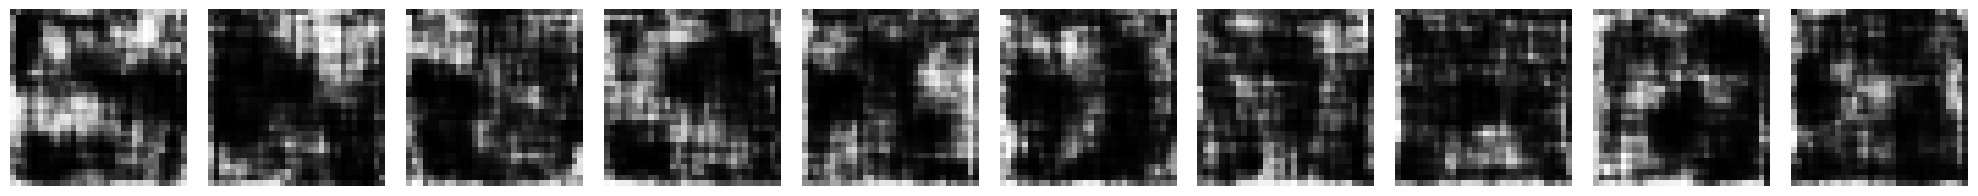

In [27]:
# Generate and display 10 conditional samples using the cGAN generator
# Display the images in grayscale
conditional_sample(cgan.generator, 10, latent_dim, gray=True)

Epoch 1/50


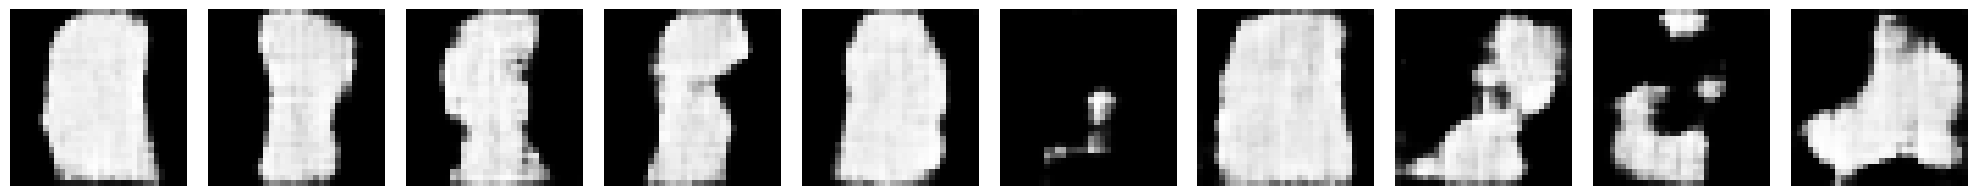

1094/1094 - 111s - 101ms/step - d_loss: 0.3126 - g_loss: 3.6006
Epoch 2/50


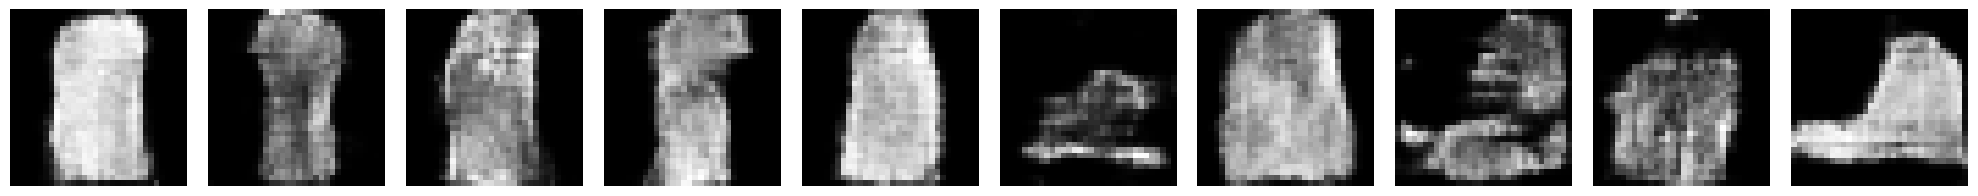

1094/1094 - 109s - 99ms/step - d_loss: 0.2802 - g_loss: 3.9156
Epoch 3/50


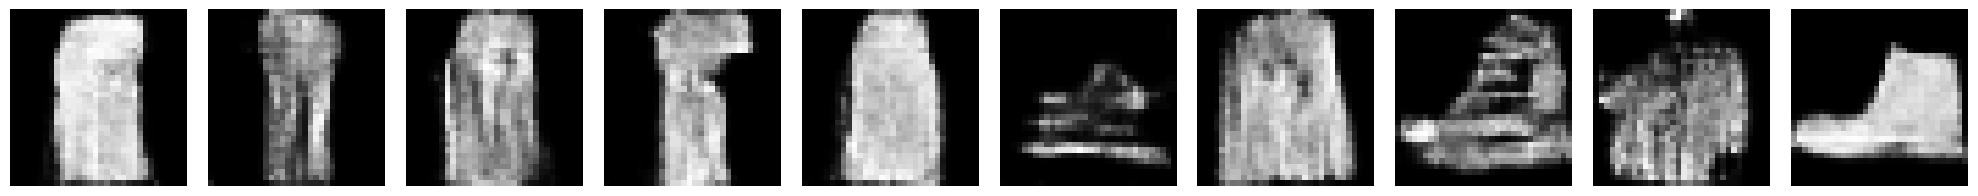

1094/1094 - 83s - 76ms/step - d_loss: 0.3429 - g_loss: 3.5199
Epoch 4/50


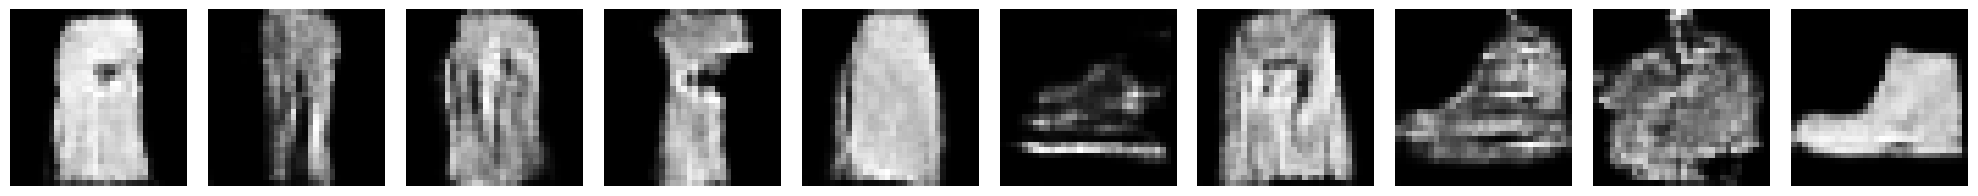

1094/1094 - 84s - 77ms/step - d_loss: 0.3714 - g_loss: 3.4195
Epoch 5/50


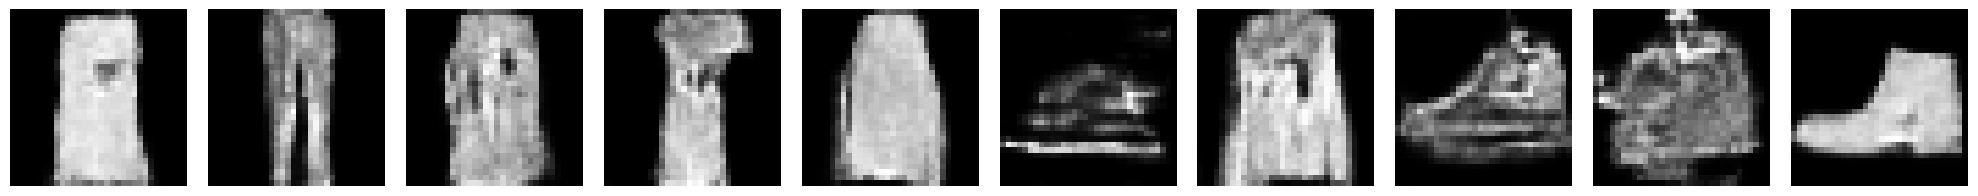

1094/1094 - 84s - 77ms/step - d_loss: 0.3825 - g_loss: 3.4138
Epoch 6/50


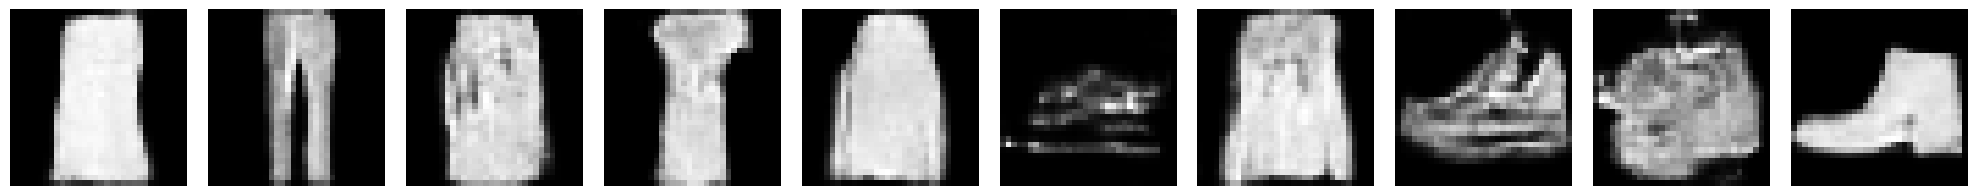

1094/1094 - 84s - 77ms/step - d_loss: 0.3978 - g_loss: 3.3295
Epoch 7/50


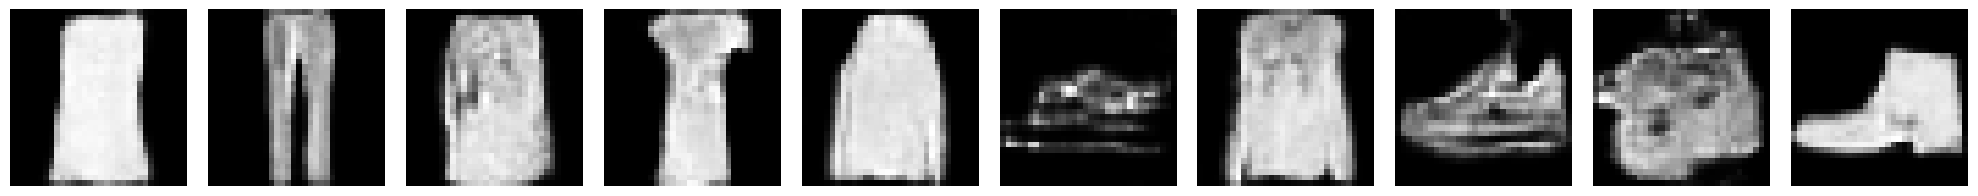

1094/1094 - 83s - 76ms/step - d_loss: 0.4221 - g_loss: 3.2486
Epoch 8/50


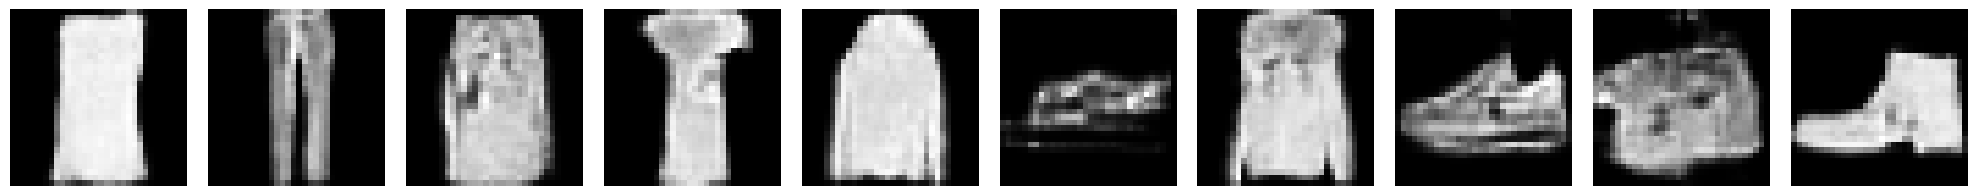

1094/1094 - 85s - 78ms/step - d_loss: 0.4359 - g_loss: 3.2008
Epoch 9/50


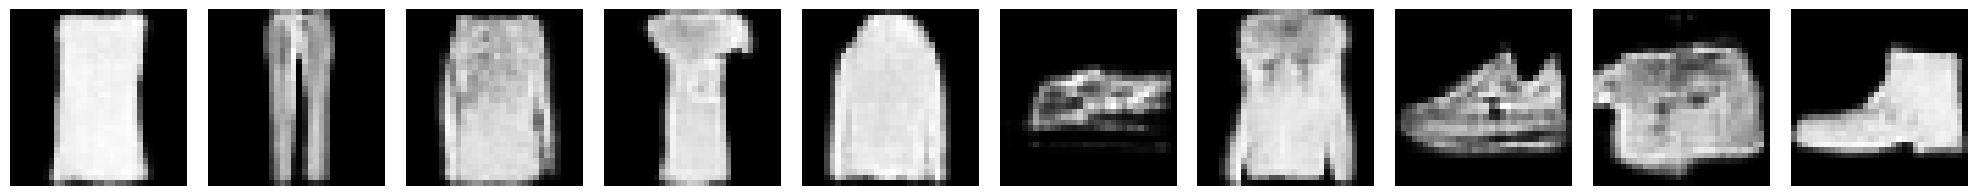

1094/1094 - 83s - 76ms/step - d_loss: 0.4485 - g_loss: 3.1924
Epoch 10/50


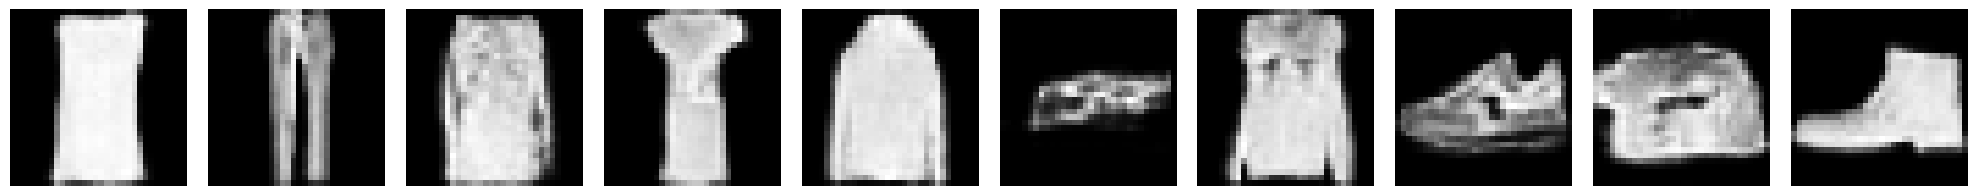

1094/1094 - 84s - 77ms/step - d_loss: 0.4553 - g_loss: 3.1580
Epoch 11/50


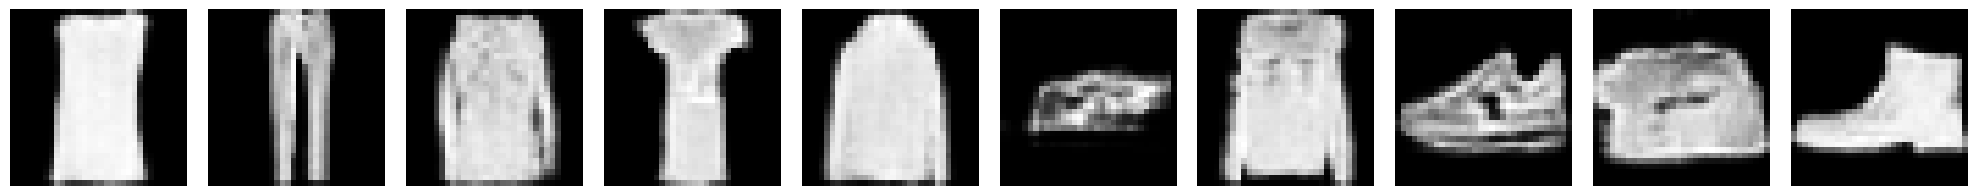

1094/1094 - 83s - 76ms/step - d_loss: 0.4516 - g_loss: 3.2026
Epoch 12/50


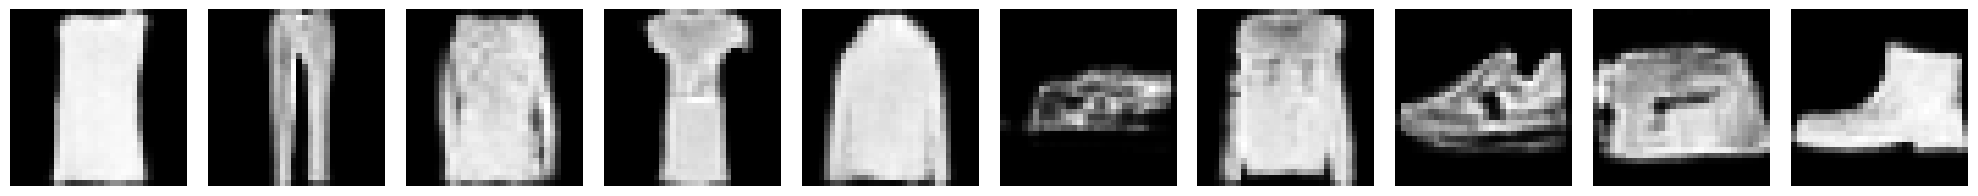

1094/1094 - 85s - 77ms/step - d_loss: 0.4459 - g_loss: 3.2169
Epoch 13/50


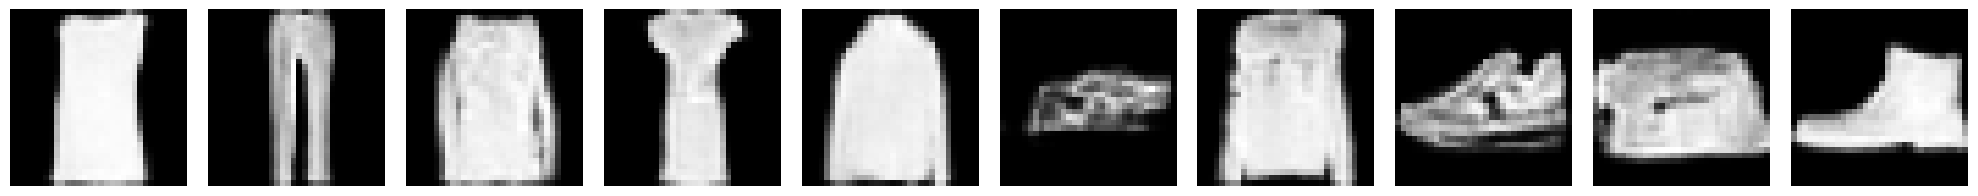

1094/1094 - 59s - 54ms/step - d_loss: 0.4376 - g_loss: 3.2978
Epoch 14/50


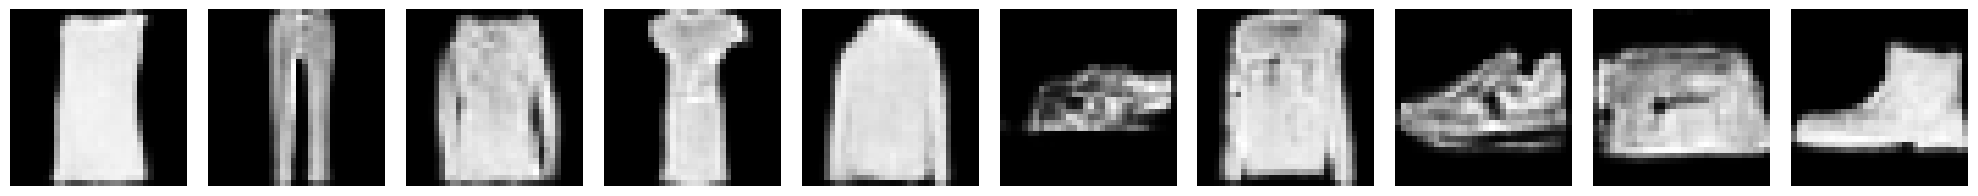

1094/1094 - 60s - 55ms/step - d_loss: 0.4311 - g_loss: 3.3967
Epoch 15/50


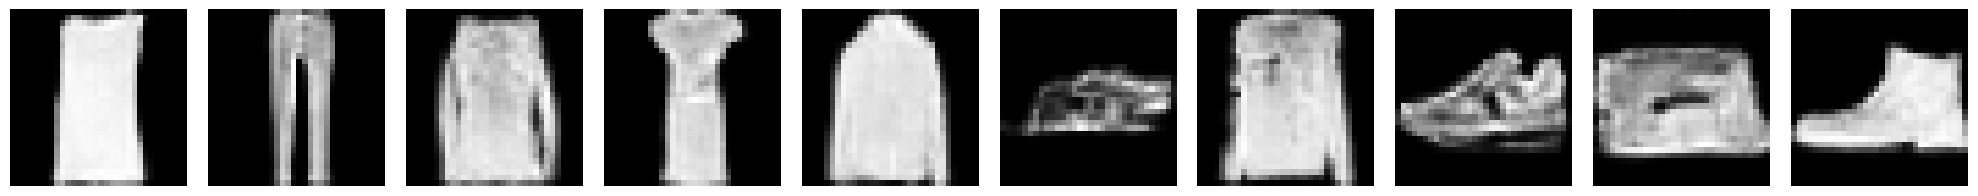

1094/1094 - 84s - 77ms/step - d_loss: 0.4176 - g_loss: 3.4087
Epoch 16/50


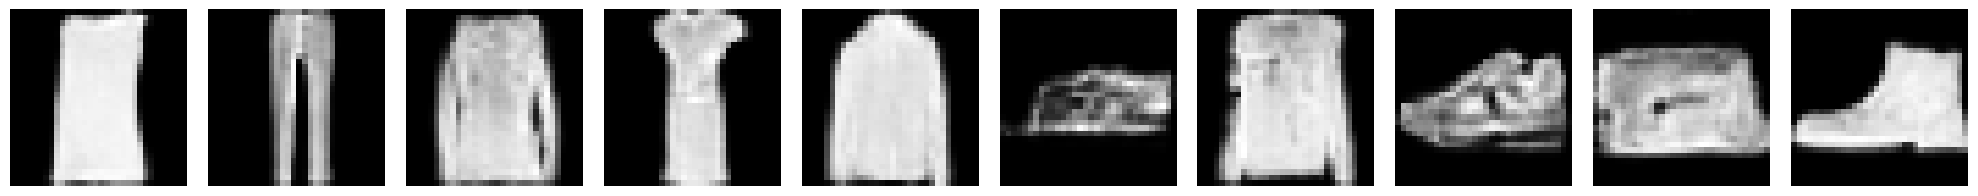

1094/1094 - 59s - 54ms/step - d_loss: 0.4047 - g_loss: 3.5469
Epoch 17/50


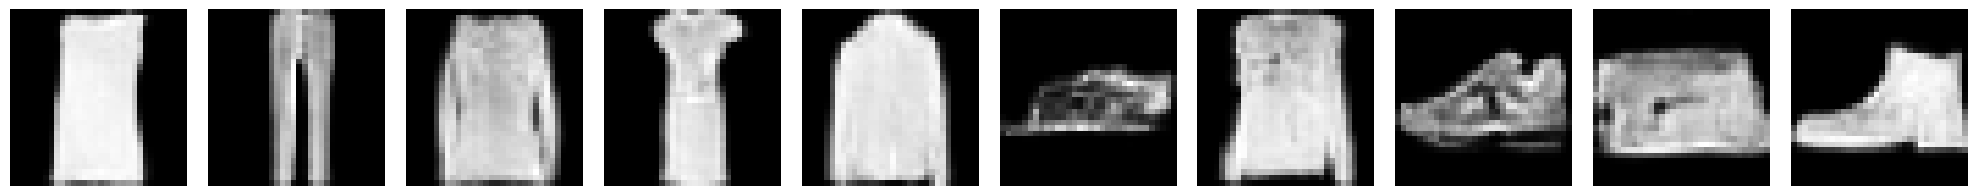

1094/1094 - 84s - 77ms/step - d_loss: 0.3972 - g_loss: 3.5959
Epoch 18/50


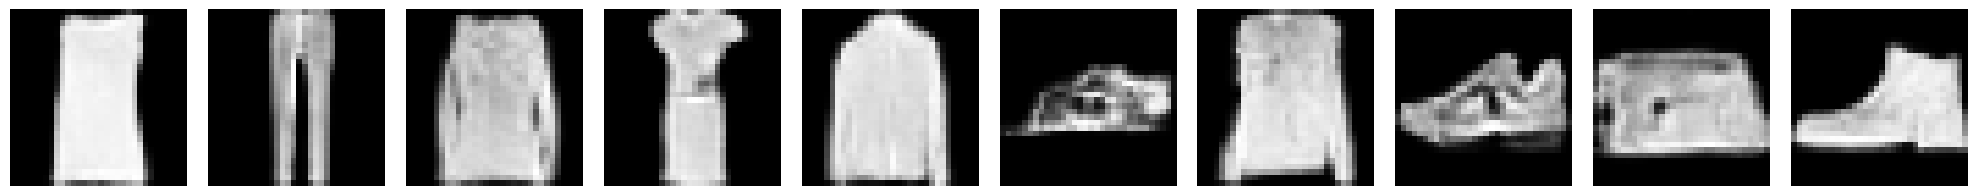

1094/1094 - 84s - 77ms/step - d_loss: 0.3860 - g_loss: 3.6875
Epoch 19/50


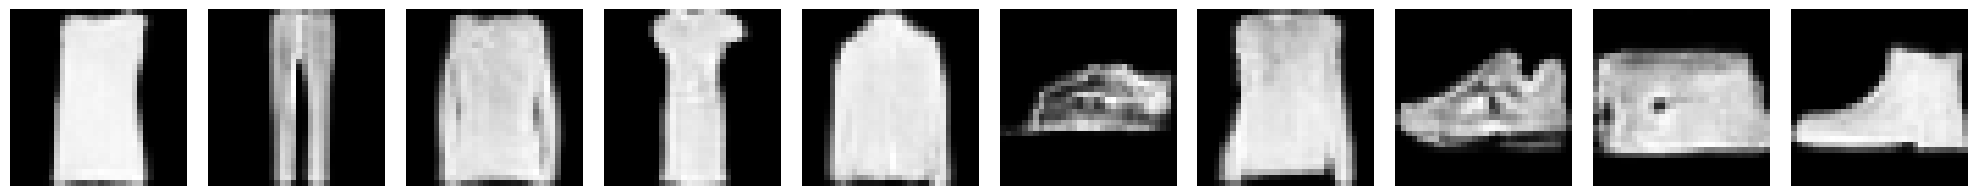

1094/1094 - 60s - 55ms/step - d_loss: 0.3702 - g_loss: 3.8231
Epoch 20/50


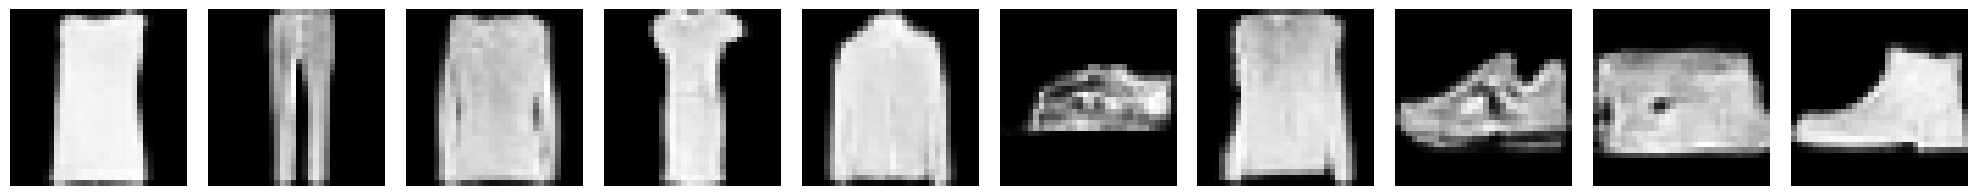

1094/1094 - 84s - 77ms/step - d_loss: 0.3625 - g_loss: 3.9212
Epoch 21/50


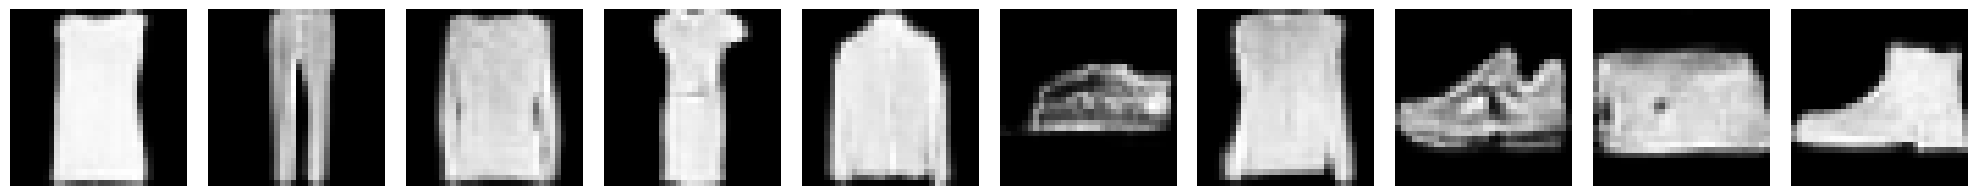

1094/1094 - 60s - 54ms/step - d_loss: 0.3495 - g_loss: 4.0070
Epoch 22/50


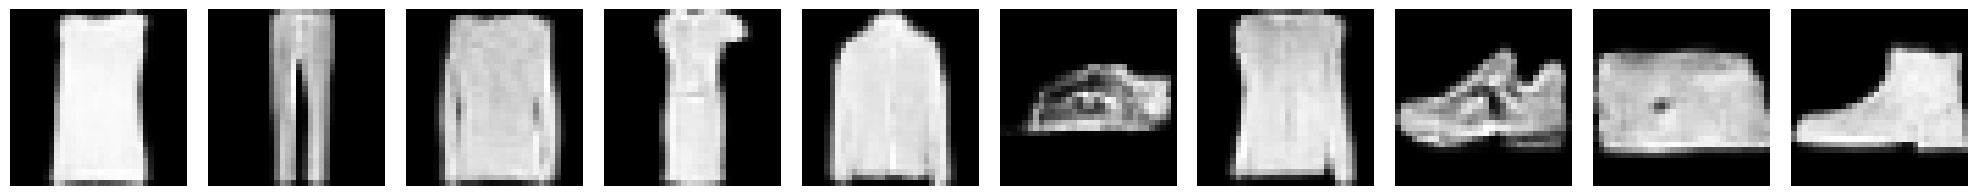

1094/1094 - 84s - 77ms/step - d_loss: 0.3432 - g_loss: 4.1078
Epoch 23/50


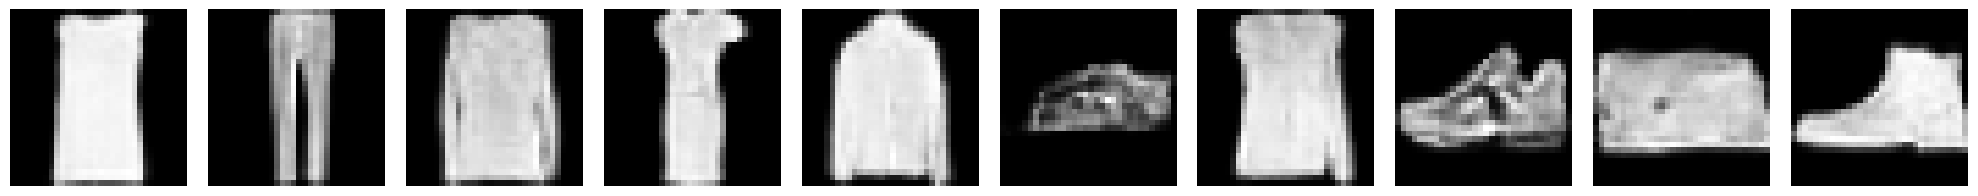

1094/1094 - 84s - 77ms/step - d_loss: 0.3345 - g_loss: 4.2323
Epoch 24/50


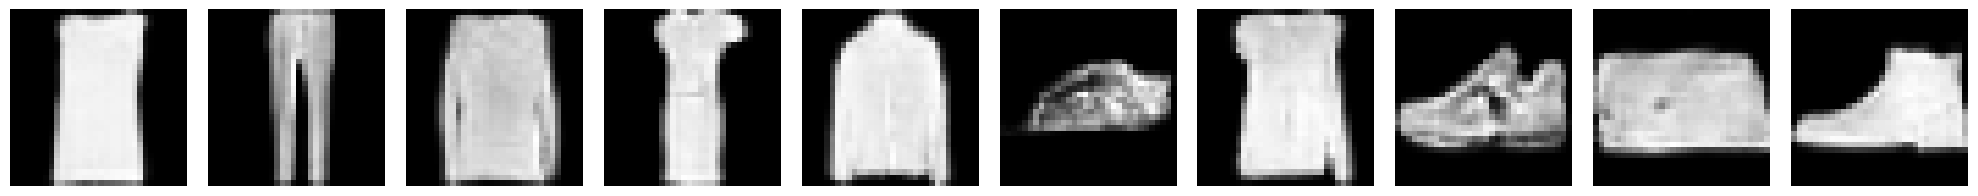

1094/1094 - 84s - 77ms/step - d_loss: 0.3256 - g_loss: 4.3155
Epoch 25/50


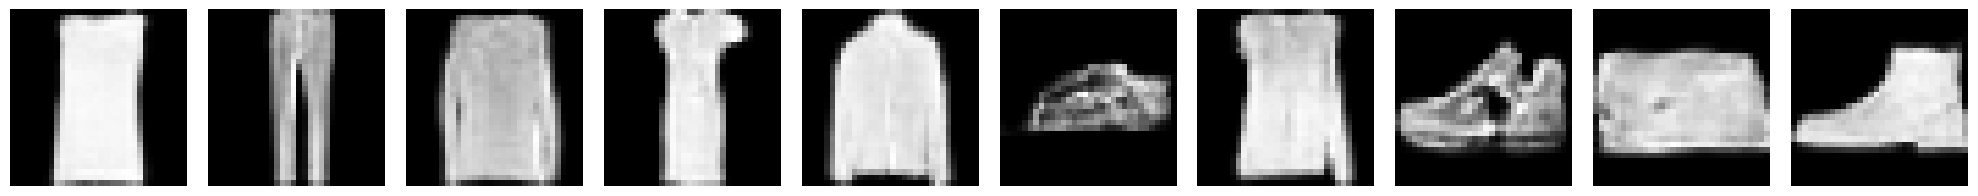

1094/1094 - 84s - 76ms/step - d_loss: 0.3189 - g_loss: 4.4327
Epoch 26/50


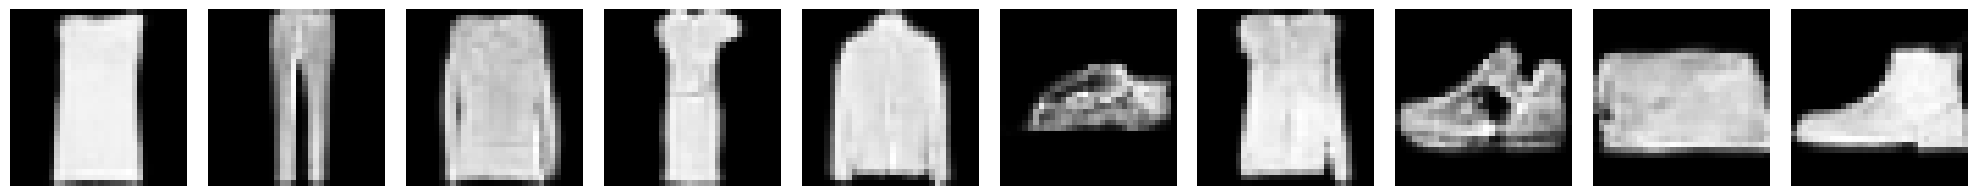

1094/1094 - 84s - 77ms/step - d_loss: 0.3137 - g_loss: 4.5232
Epoch 27/50


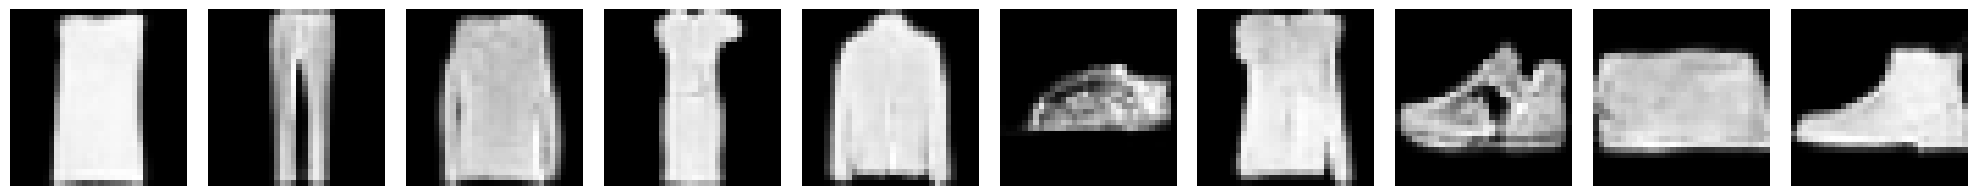

1094/1094 - 85s - 77ms/step - d_loss: 0.3001 - g_loss: 4.5881
Epoch 28/50


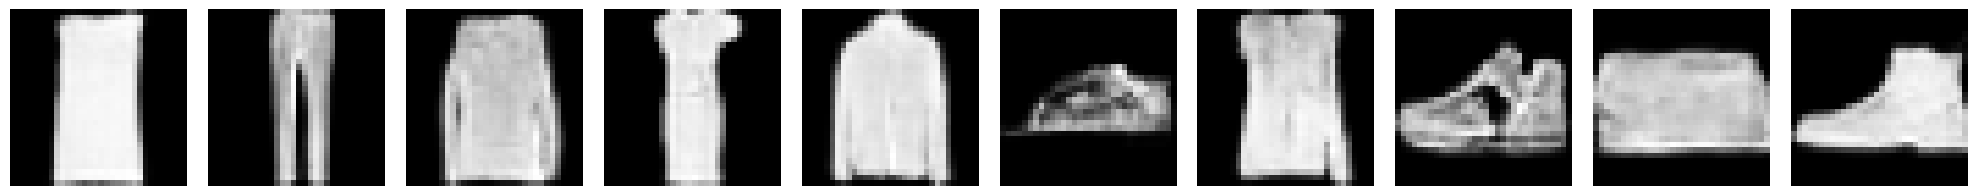

1094/1094 - 84s - 77ms/step - d_loss: 0.2964 - g_loss: 4.6816
Epoch 29/50


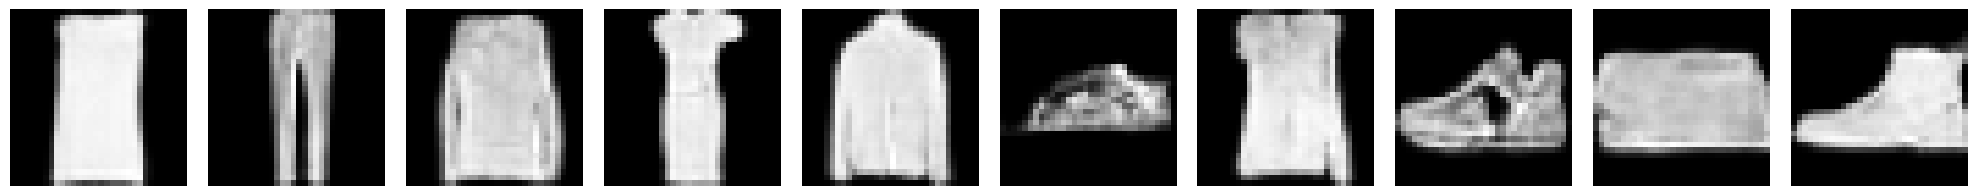

1094/1094 - 84s - 77ms/step - d_loss: 0.2934 - g_loss: 4.7711
Epoch 30/50


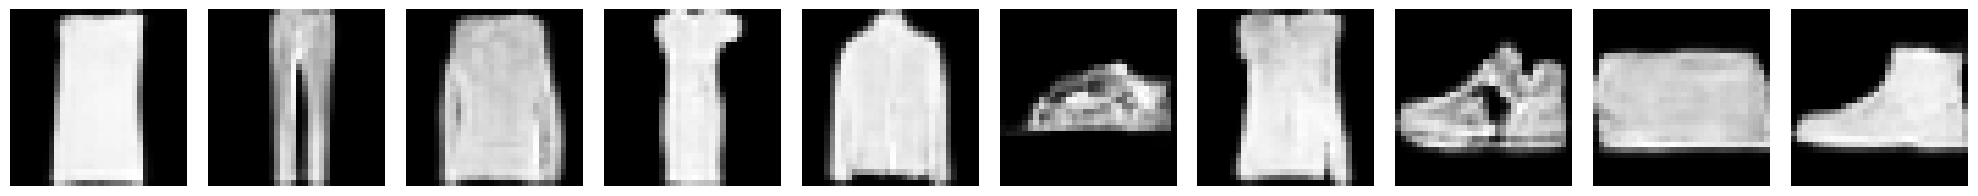

1094/1094 - 84s - 77ms/step - d_loss: 0.2823 - g_loss: 4.8677
Epoch 31/50


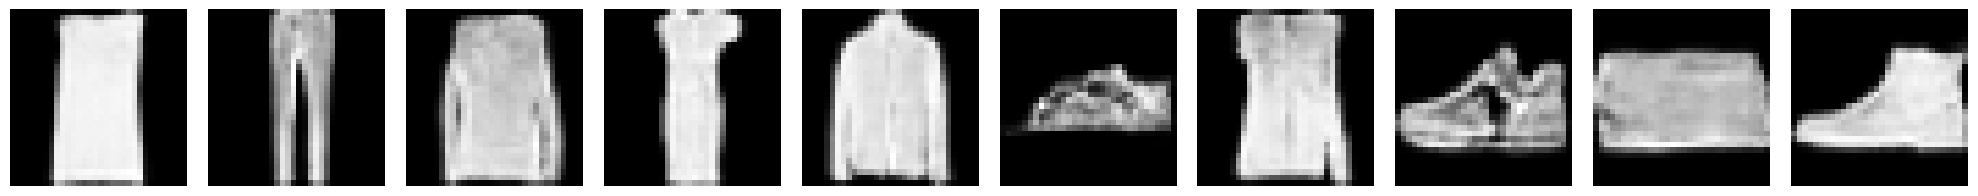

1094/1094 - 83s - 76ms/step - d_loss: 0.2825 - g_loss: 5.0036
Epoch 32/50


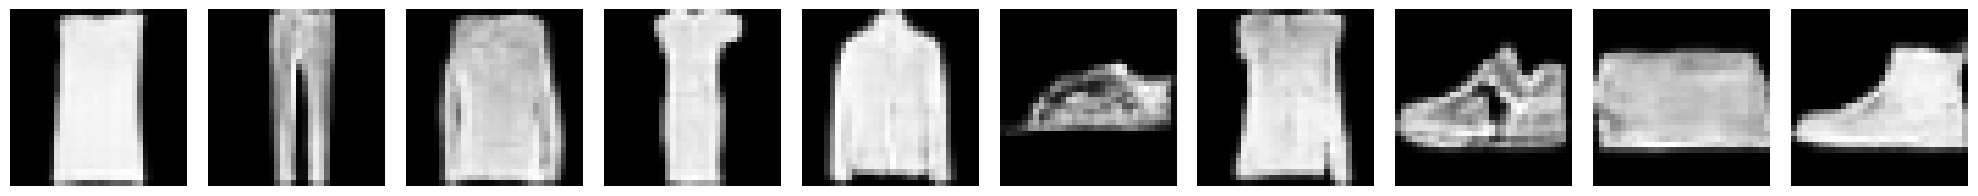

1094/1094 - 85s - 77ms/step - d_loss: 0.2762 - g_loss: 5.0637
Epoch 33/50


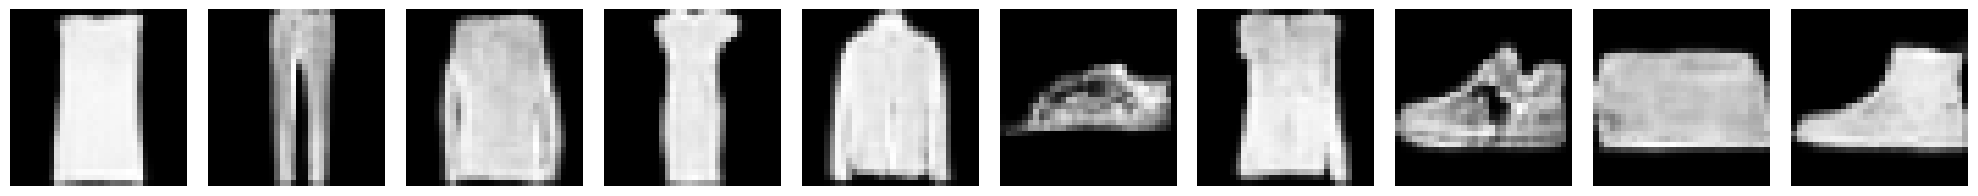

1094/1094 - 59s - 54ms/step - d_loss: 0.2638 - g_loss: 5.1229
Epoch 34/50


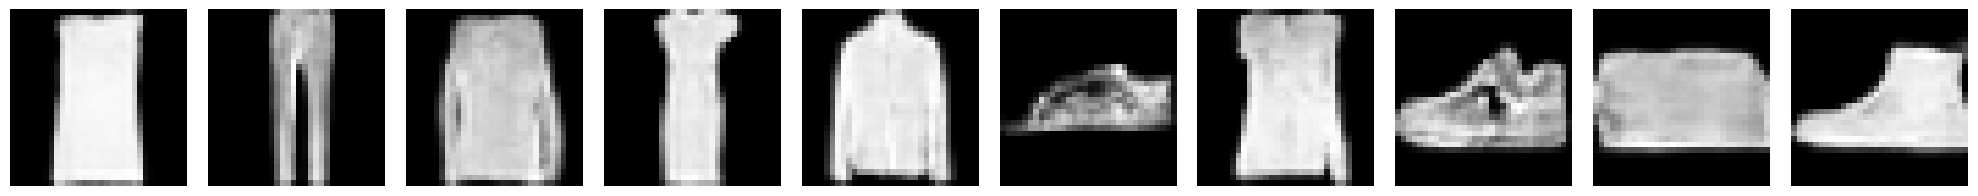

1094/1094 - 60s - 55ms/step - d_loss: 0.2621 - g_loss: 5.2028
Epoch 35/50


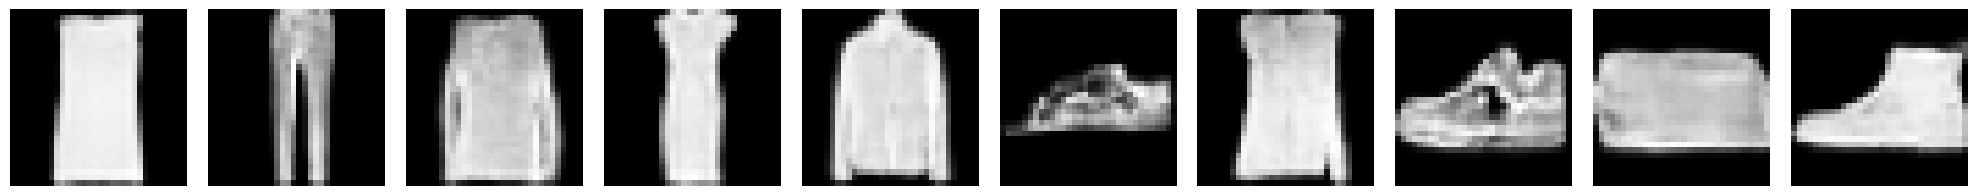

1094/1094 - 84s - 77ms/step - d_loss: 0.2566 - g_loss: 5.3480
Epoch 36/50


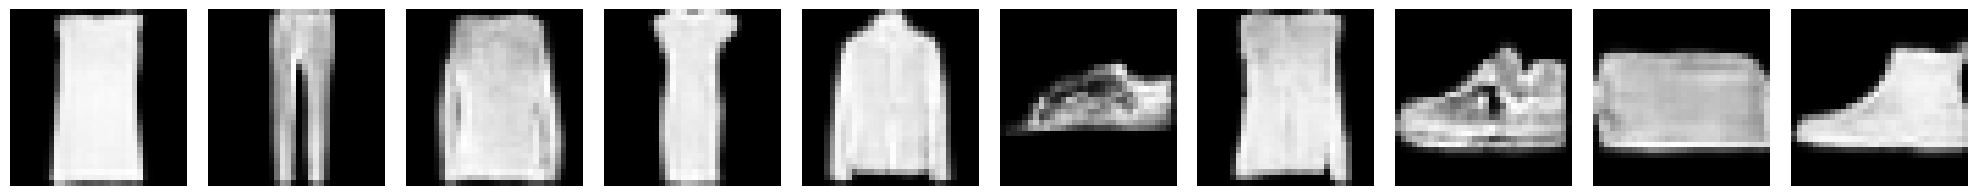

1094/1094 - 60s - 55ms/step - d_loss: 0.2488 - g_loss: 5.4226
Epoch 37/50


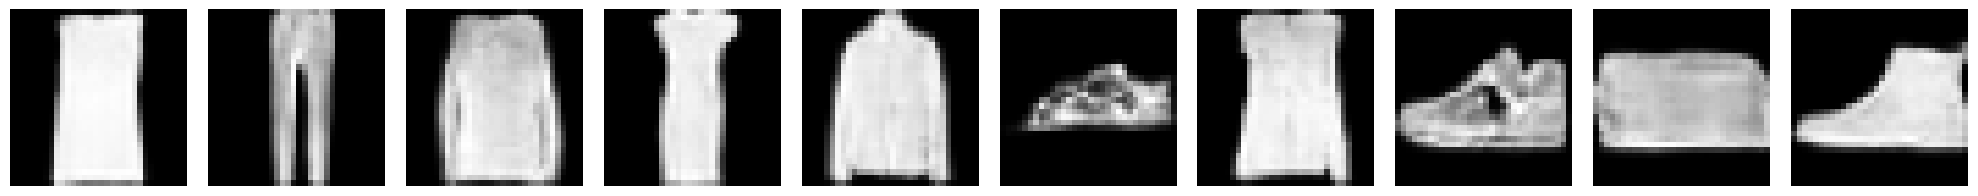

1094/1094 - 84s - 77ms/step - d_loss: 0.2493 - g_loss: 5.4948
Epoch 38/50


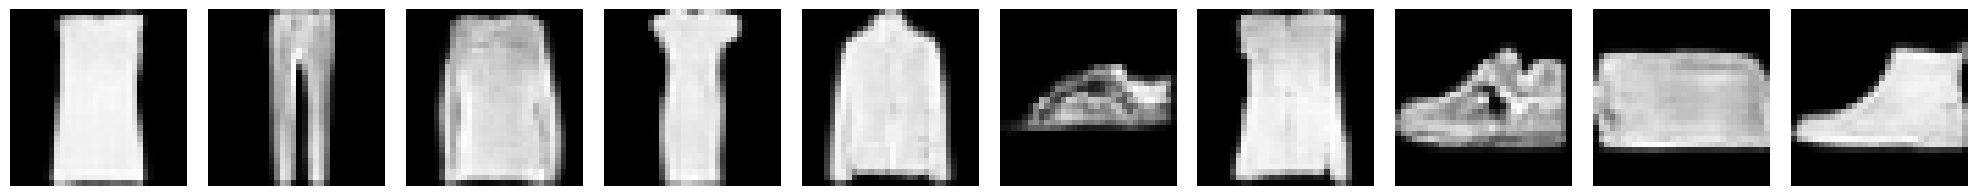

1094/1094 - 61s - 56ms/step - d_loss: 0.2514 - g_loss: 5.4707
Epoch 39/50


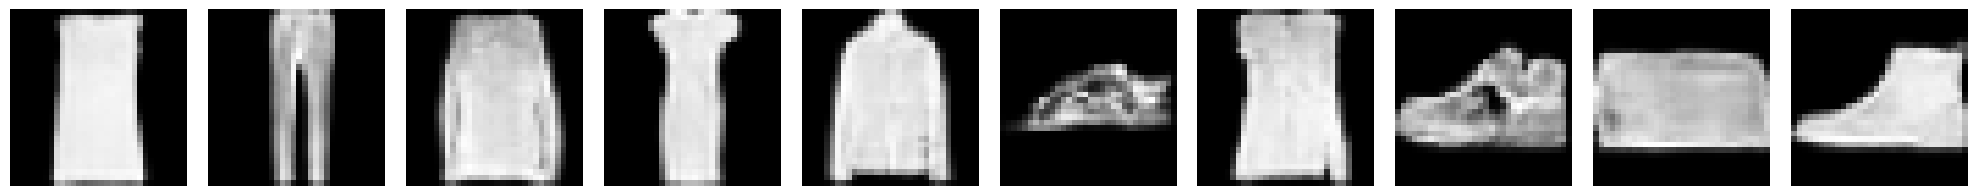

1094/1094 - 60s - 55ms/step - d_loss: 0.2375 - g_loss: 5.6672
Epoch 40/50


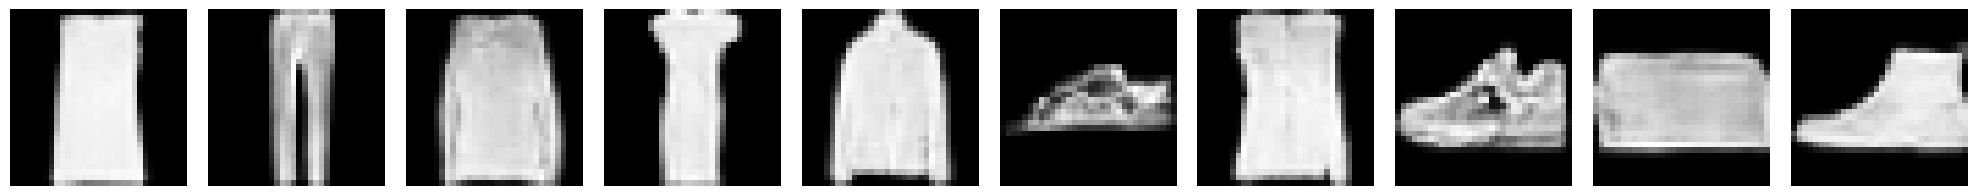

1094/1094 - 85s - 77ms/step - d_loss: 0.2348 - g_loss: 5.6613
Epoch 41/50


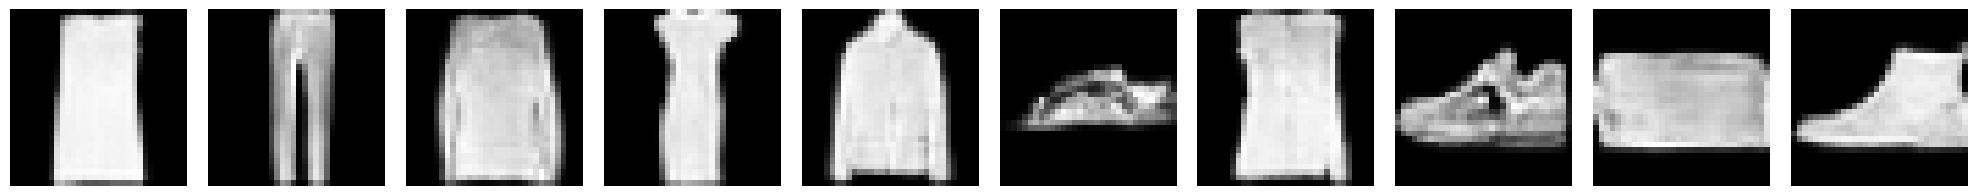

1094/1094 - 84s - 77ms/step - d_loss: 0.2341 - g_loss: 5.7812
Epoch 42/50


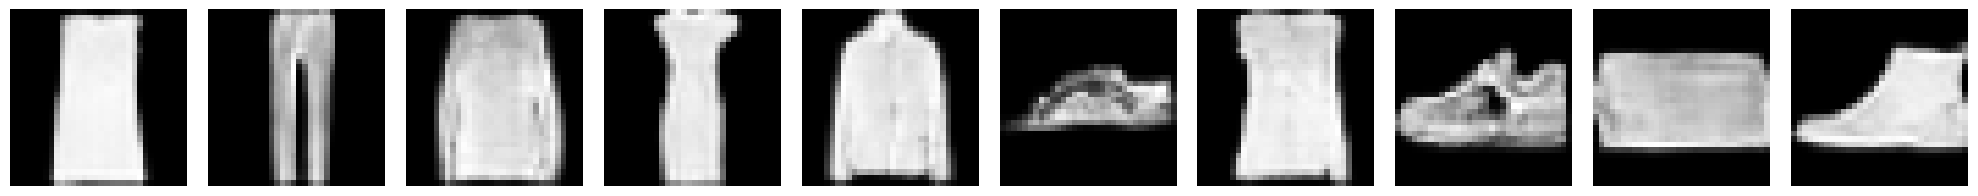

1094/1094 - 84s - 77ms/step - d_loss: 0.2284 - g_loss: 5.9116
Epoch 43/50


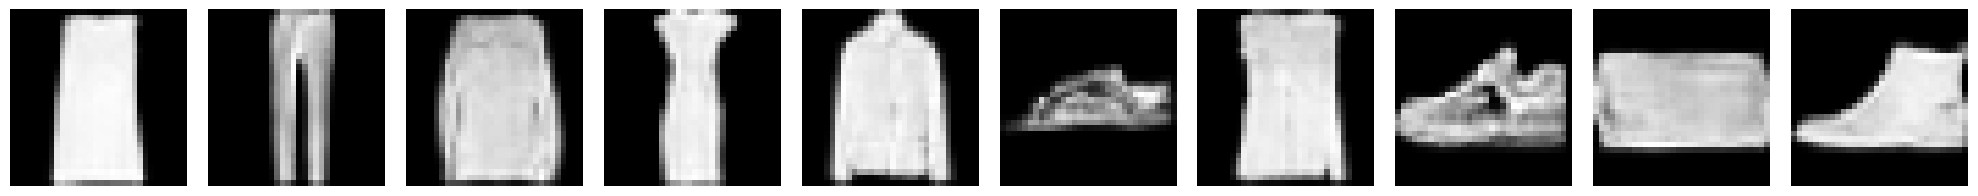

1094/1094 - 83s - 76ms/step - d_loss: 0.2229 - g_loss: 5.8902
Epoch 44/50


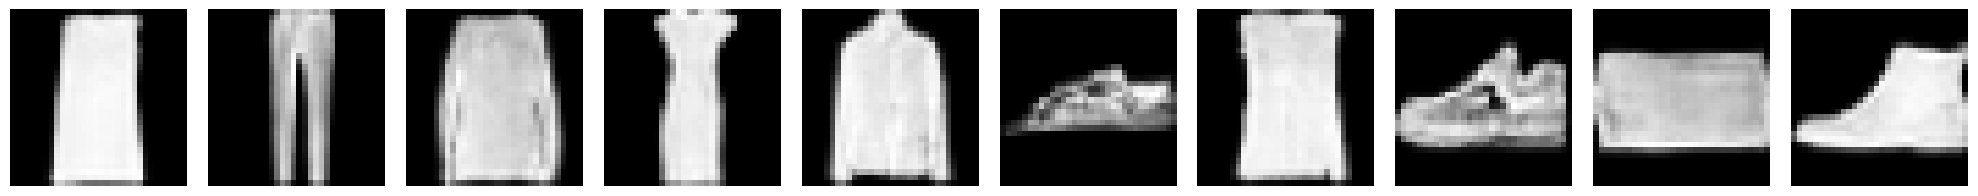

1094/1094 - 60s - 54ms/step - d_loss: 0.2185 - g_loss: 5.9731
Epoch 45/50


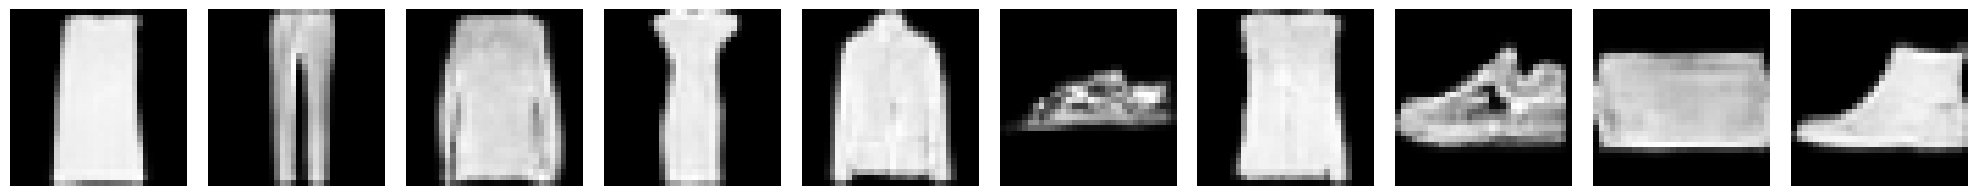

1094/1094 - 84s - 77ms/step - d_loss: 0.2182 - g_loss: 6.0588
Epoch 46/50


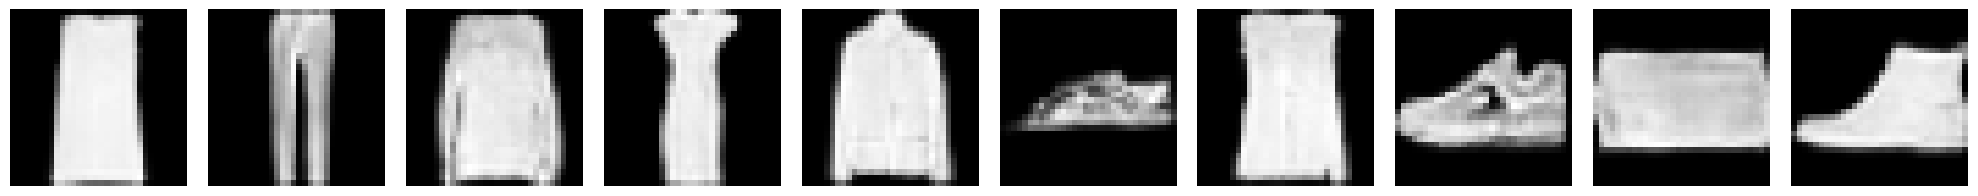

1094/1094 - 84s - 77ms/step - d_loss: 0.2127 - g_loss: 6.0662
Epoch 47/50


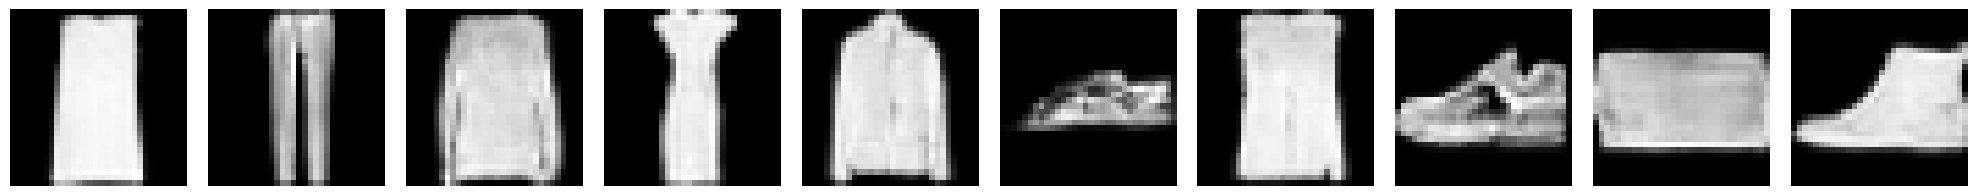

1094/1094 - 60s - 55ms/step - d_loss: 0.2070 - g_loss: 6.1350
Epoch 48/50


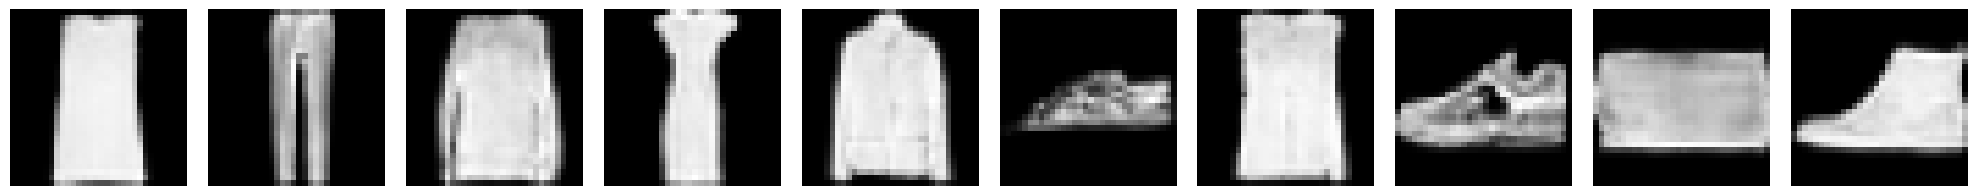

1094/1094 - 85s - 78ms/step - d_loss: 0.2113 - g_loss: 6.1032
Epoch 49/50


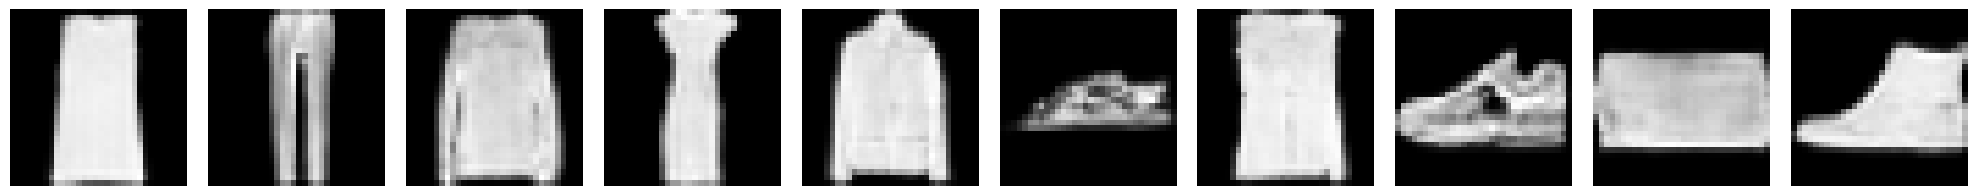

1094/1094 - 83s - 76ms/step - d_loss: 0.2108 - g_loss: 6.1504
Epoch 50/50


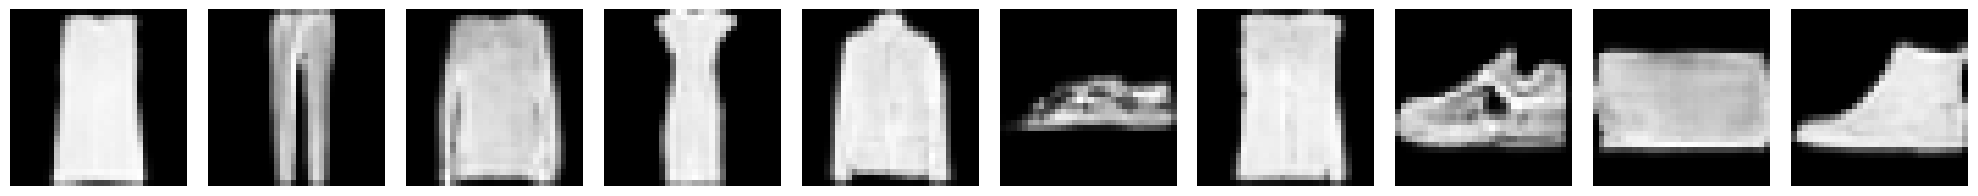

1094/1094 - 84s - 77ms/step - d_loss: 0.1992 - g_loss: 6.3079


In [28]:
# Train the conditional GAN model with the dataset and specified parameters
c_history = cgan.fit(
    X,
    y,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[ConditionalGANMonitor(name='fashionmnist_cgan', gray=True)],
    verbose=2
).history

# Save the trained conditional GAN generator model
cgan.generator.save('fashionmnist_cgan.keras')

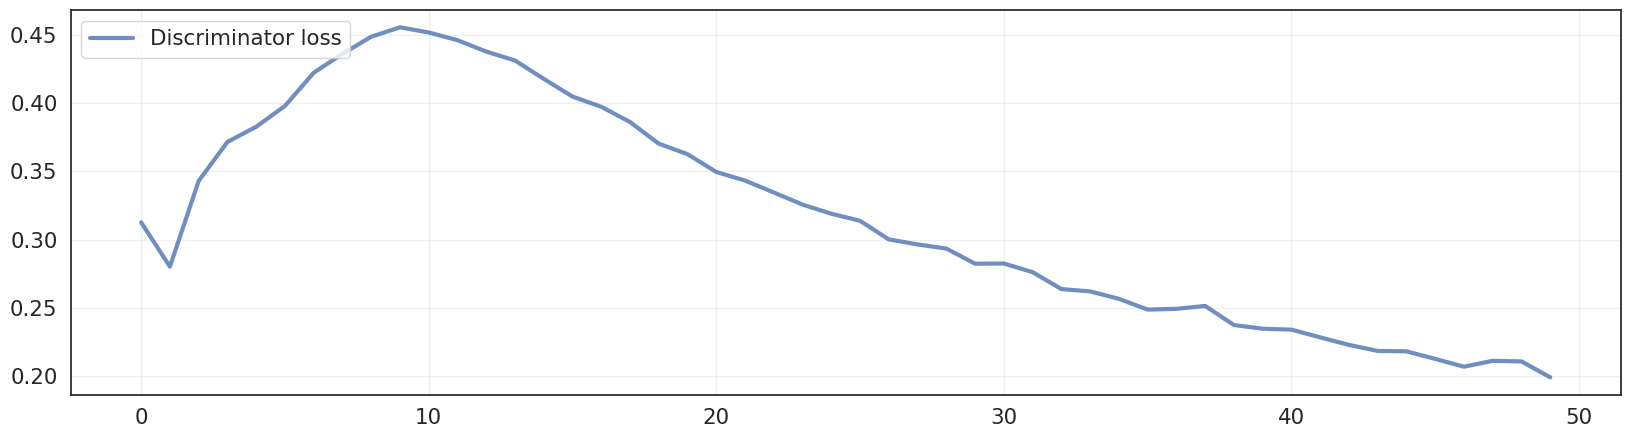

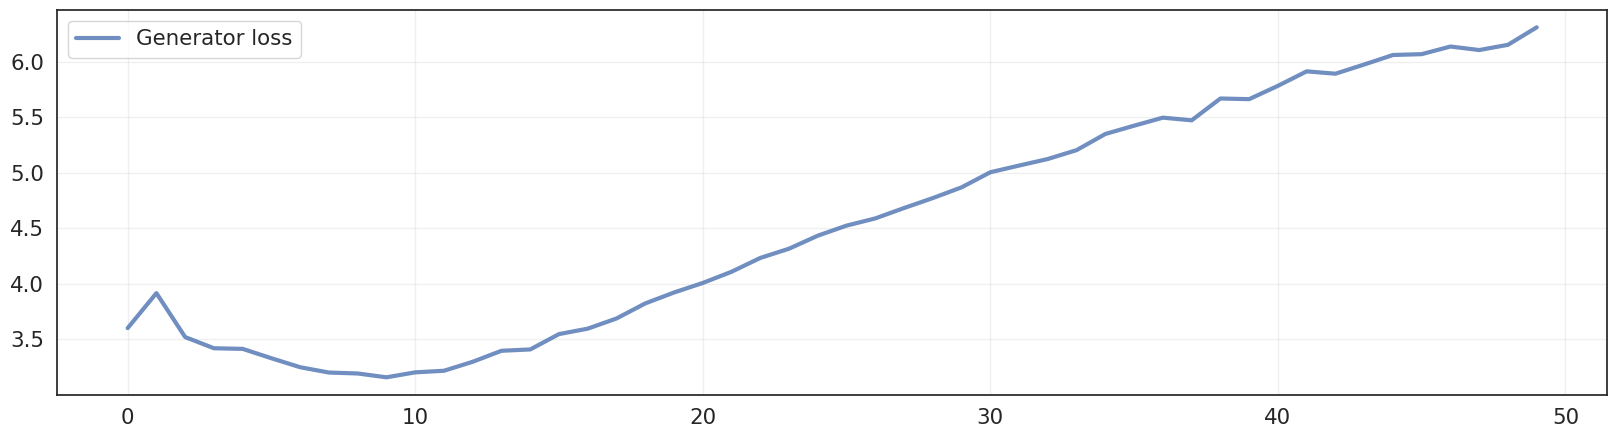

In [29]:
# Plot the discriminator loss during training
plt.figure(figsize=(20, 5))
plt.plot(c_history['d_loss'], label='Discriminator loss', alpha=0.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

# Plot the generator loss during training
plt.figure(figsize=(20, 5))
plt.plot(c_history['g_loss'], label='Generator loss', alpha=0.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

# Display the plots
plt.show()

## 🕹️ Use the Model - Make Inference

In [30]:
# Load the saved conditional GAN generator model
conditional_gan_generator = tfk.models.load_model('fashionmnist_cgan.keras')

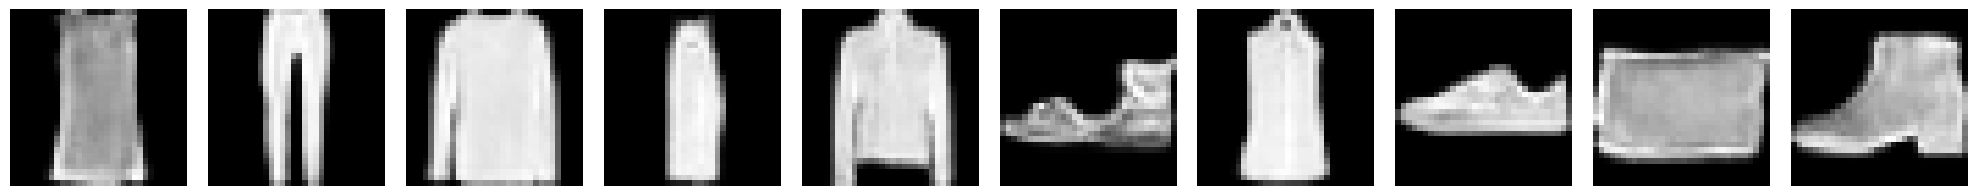

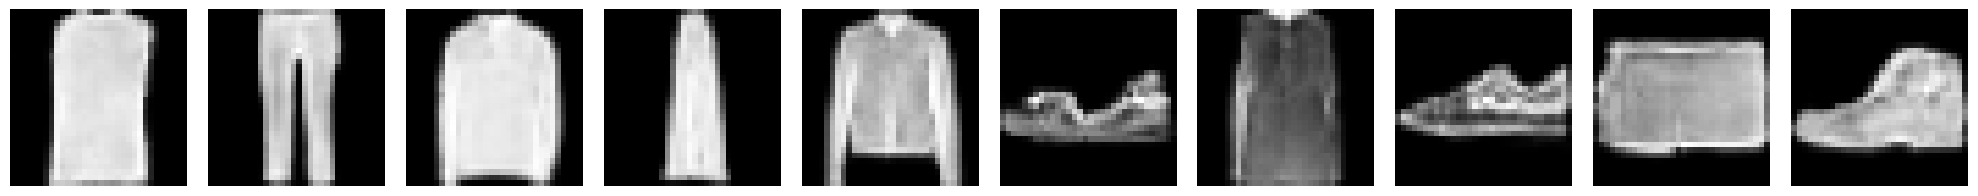

In [31]:
# Generate and display 10 conditional samples using the loaded conditional GAN generator
# Disable fixed random seed and display images in grayscale for both invocations
conditional_sample(conditional_gan_generator, 10, latent_dim, fixed=False, gray=True)
conditional_sample(conditional_gan_generator, 10, latent_dim, fixed=False, gray=True)

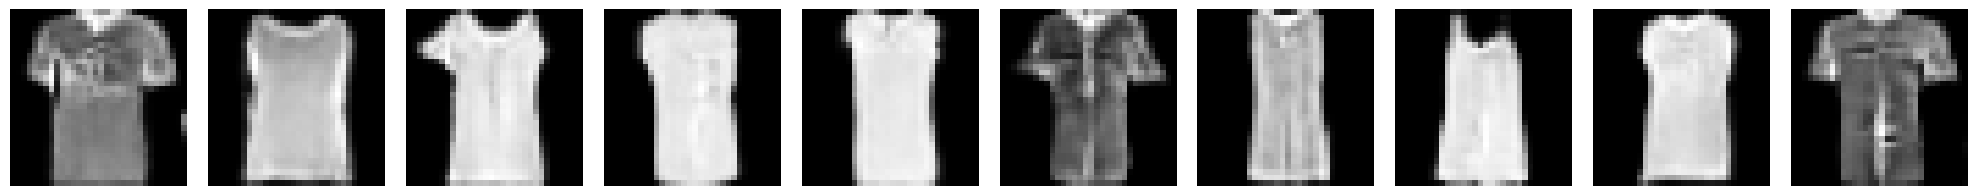

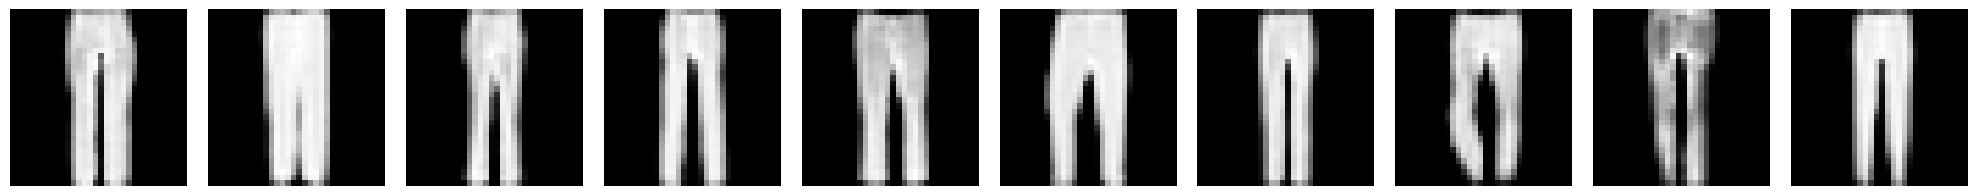

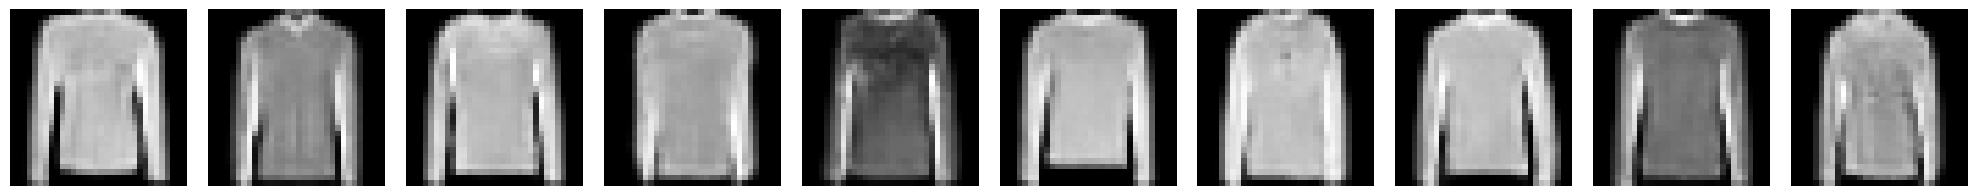

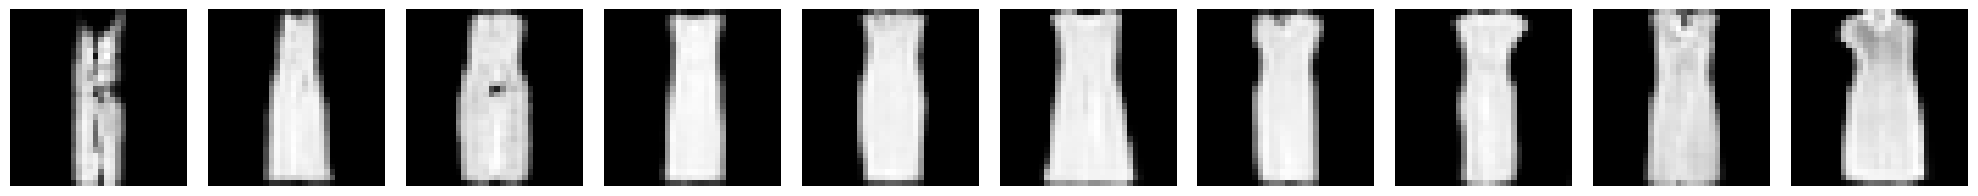

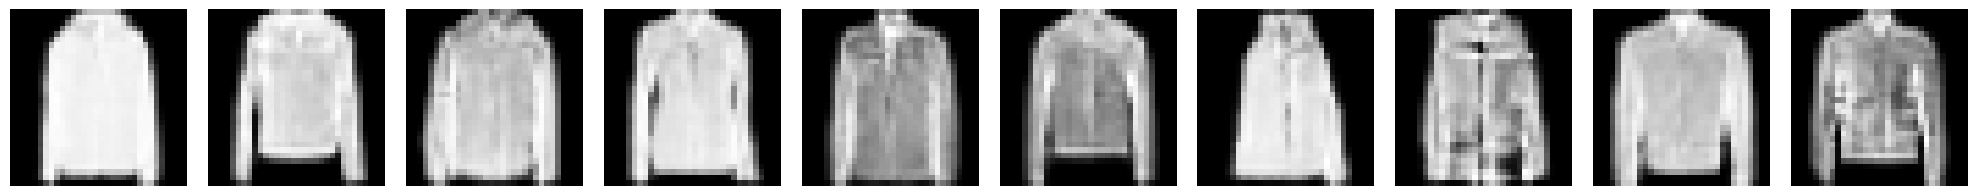

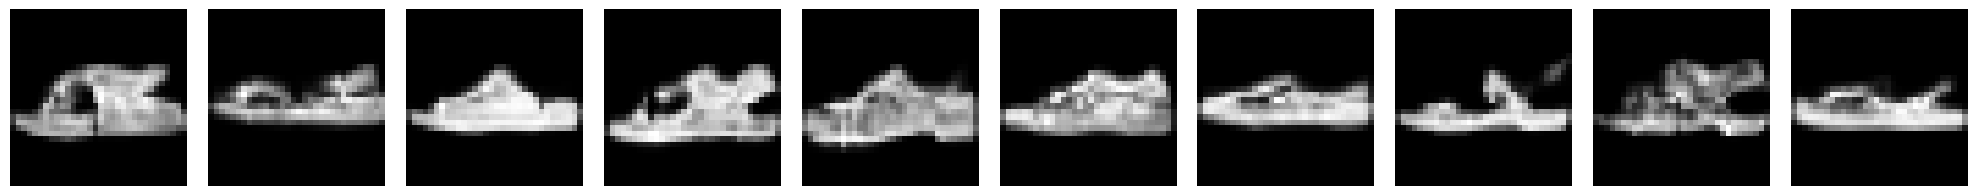

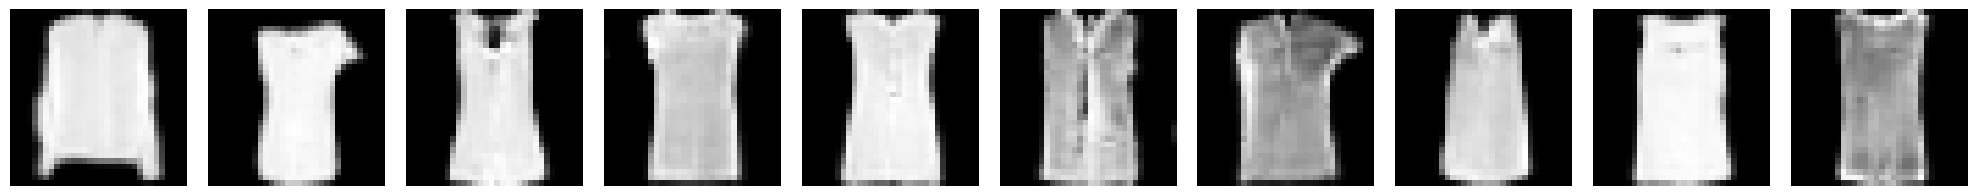

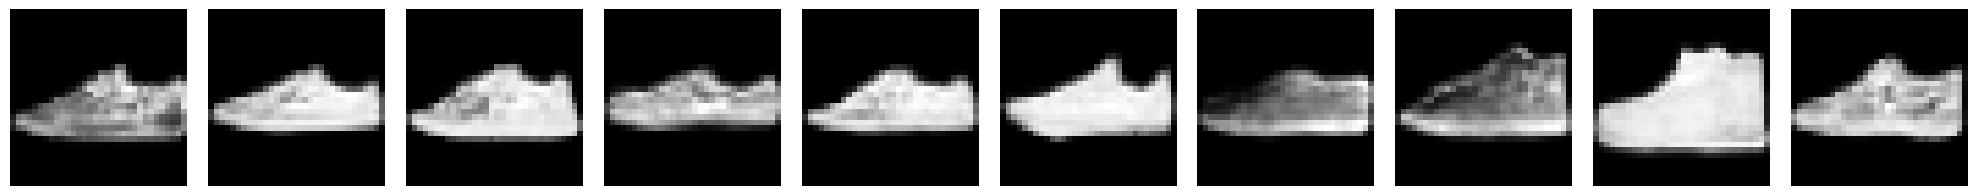

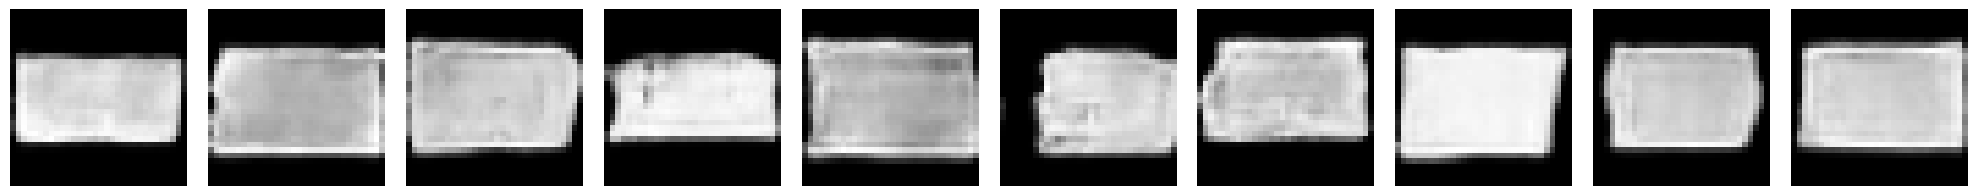

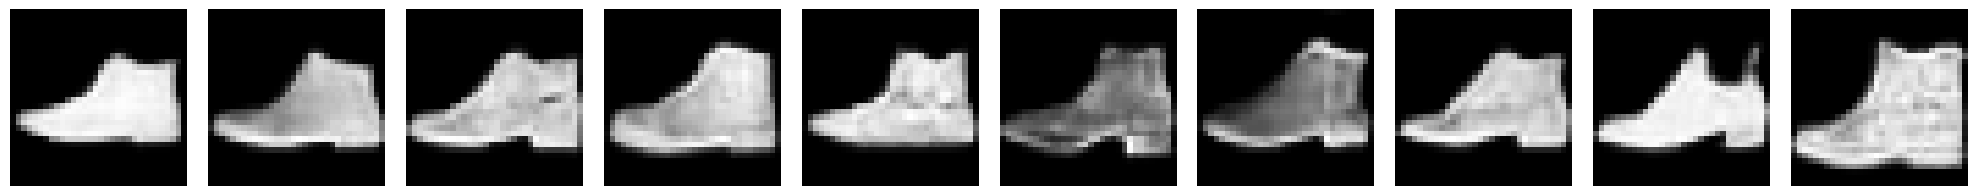

In [32]:
# Generate and display 10 conditional samples for each class using the loaded conditional GAN generator
# Disable fixed random seed and display images in grayscale for each class
for i in range(num_classes):
    conditional_sample(conditional_gan_generator, 10, latent_dim, gray=True, fixed=False, label=i)